# Development of Probability of Default model
The purpose of this exercise is to develop Probabality of Default model for a portfolio containing a large and diversified pool of customers. The process will also include testing model's predictive power and calibration precision. As a tool of development Python was choosen for its usability qualities. As developing environment Jupyter Notebook is used.

### The concept
The concept of Probability of Default model is analysis of so called good and bad observations. In case of good/bad analysis observation is a state of a given client or contract at specific date (usually reporting date). Explanatory variables of this observation are features that describe its current state. Dependent variable (usually called target) is an indicator whether this contract or client defaulted within predertmined period of time (for the purpose of a current analysis defulat within 12 months is used). Set of such observations for one date comprise portfolio for a given reporting date. To obtain panel data to be used in good/bad analysis portfolios for different dates are merged into one dataset. The dataset to be used in this analysis is exactly the one described above.

### The approach
Now when we discussed the concept of analysis let's dive into the approach for the analysis. In real world there are just two possible states of the client or contract within 12 months - defaulted or not defaulted. We want to predict this state based on an information we have at the moment. Such type of a problem is called binary classification. In such problem object with unknown class need to be classified into one of two possible classes. We need to constract an algorithm which will assign the class to an object based on infromation provided. For binary classification the logic is follwing: first calculate the probability that object belongs to a given class. That probability is actually a probability of default in our case, i.e. probability that observation is bad or that contact will default within 12 months. For the purpose of Probability of Default modeling usually logistic function is used:

$$ p(x)= {1\over 1+e^{-(\beta_0+\beta_1x_1+...+\beta_nx_n)}} $$

where $\beta_i$ are weights for different factors (i.e. what is the strenght of factor's influence on probability)

After the choice of probabilty function we can write likelihood function as a product of probabilities for entire sample and maximize it with respect to the set of weights $\beta_i$. 

In classical classification problem specific class should be assigned to an object, thus the theshhold for probability is estimated as well. Since the scope of our exercise is Probabilty of Default model there is no need to estimate optimal theshold.

### Structure
A highlevel structure of this model development and validation process is following:
- Data Import and initial inspection
- Exploration of data descriptive statistics
- Single Factor Analysis
- Multiple Factor Analysis

#### Sources used for the development:
- Studies on the Validation of Internal Rating Systems, Working Paper No. 14, 2005, BCBS
- Credit Risk Scorecards, Developing and Implementing Intelligent Credit Scoring, Naeem Siddiqi, 2006
- A practical approach to validating a PD model, Lydian Medema et al., Journal of Banking & Finance, Volume 33, Issue 4, 2009
- How to Measure the Quality of Credit Scoring Models, Martin ŘEZÁČ & František ŘEZÁČ, Czech Journal of Economics and Finance, 61, 2011, no. 5
- Notes on courses of Econometrics for several modules taken in New Economic School in the period of 2010-2012, lecturer Stanislav Anatolyev, https://scholar.google.com/citations?user=T2OAOI0AAAAJ&hl=ru
- Material and notes on course of Advanced Data Science led by Victor Kantor, https://github.com/applied-data-science/ml2018jan_feb
***

## Importing neccessary for the analysis libraries and dowloading raw data

In [1]:
import pandas as pd
import numpy as np
import datetime
from dateutil import relativedelta

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.linear_model import LinearRegression
#from sklearn import preprocessing
#from sklearn.linear_model import LogisticRegression

from scipy import stats

import time

#import warnings
#warnings.filterwarnings("ignore")

code_time = time.time()

C:\Users\Konstantin.Singurov\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


__Note:__ Before downloading 'Asg1_BuildModel_csv.csv' one more column was added (Total_sales_1e_06). pandas.read_csv reads Total_sales(amount) as string, so pandas.to_numeric should be used. Unfortunatelly the is issue with converting string to numbers when there are more than 20 digits. So before downloading 'Total_sales_1e_06' was created as Total sales divided by 10^6

In [2]:
#data = pd.read_csv('Asg1_BuildModel_csv.csv', encoding='cp1252', sep=',', na_filter=False, thousands=',')
data = pd.read_csv('Asg1_BuildModel_csv_edited.csv', encoding='cp1252', sep=';', na_filter=False)
data.head(5)

,ID,RATING_DATE,Leverage_percentage,"Region with High_Risk ( 0 = no, 1=yes)","Renting_space( 0 = no, 1 = yes)","Product_Type_RealEstate(0= no, 1 =yes)",LoancontractperBook_value(percentage),"Industry_Pub_Eq_Hotel_Trans_Ind( 0 = no, 1 = yes)","Car( 0 = no, 1 = yes)","Payment_arrears_12_months ( 0 = no, 1 = yes)","Ind_Construction( 0 = yes, 1 = no)","Region_Low_Risk( 0 = no, 1 = yes)",Solvency_ratio_ per_Y(percentage),"High_risk_Region ( 0 = no, 1 = yes)",Total_sales(amount),DEFAULT,into_default_date,INTODEFAULT_flag_on12monthsperformancewindow,no_of_days_diff_between_rating_and_default,Total_sales_1e_06
0,72023448,22Apr2011,1.224812,0,0,0,0.990909,0,1,0,0,1,0.897156,0,"130,481.00",0,,0,0,0.130481
1,72023448,24May2011,1.224812,0,0,0,0.985249,0,1,0,0,1,0.892032,0,"127,584.00",0,,0,0,0.127584
2,72023448,22Jun2011,1.224812,0,0,0,0.979454,0,1,0,0,1,0.886785,0,"124,679.00",0,,0,0,0.124679
3,72023448,28Jul2011,1.224812,0,0,0,0.970997,0,1,0,0,1,0.879128,0,"121,766.00",0,,0,0,0.121766
4,72023448,26Aug2011,1.224812,0,0,0,0.962222,0,1,0,0,1,0.871183,0,"118,842.00",0,,0,0,0.118842


***
### Data dictionary:
- __INTODEFAULT_flag_on12monthsperformancewindow__: dependent variable
- 9 categorical explanatory variables with values 0 and 1:
    - __Region with High_Risk ( 0 = no, 1=yes)__
    - __Renting_space( 0 = no, 1 = yes)__
    - __Product_Type_RealEstate(0= no, 1 =yes)__
    - __Industry_Pub_Eq_Hotel_Trans_Ind( 0 = no, 1 = yes)__
    - __Car( 0 = no, 1 = yes)__
    - __Payment_arrears_12_months ( 0 = no, 1 = yes)__
    - __Ind_Construction( 0 = yes, 1 = no)__
    - __Region_Low_Risk( 0 = no, 1 = yes)__
    - __High_risk_Region ( 0 = no, 1 = yes)__: (?) duplicate of Region with High_Risk ( 0 = no, 1=yes)
- 4 numerical explanatory variables:
    - __Leverage_percentage__
    - __LoancontractperBook_value(percentage)__
    - __Solvency_ratio_per_Y(percentage)__
    - __Total_sales(amount)__ 
- __Total_sales_1e_06__: auixiliary variable which was created before dowloading raw data (it will be dropped after type convertion and substitution of __Total_sales(amount)__). Has string format, needs to be converted to numerical format.
- __ID__: unique client (or contract) identification number
- __RATING_DATE__: date when correspinding ID was rated. The fromat is not recognized by Python, needs to be converted to proprietary Python date format
- __DEFAULT__: empty column
- __into_default_date__: default date has Excel date format, needs to be converted to proprietary Python date format
- __no_of_days_diff_between_rating_and_default__
***

__Rename columns with more convinient names__ <br> It is better to avoid brackets and spaces in the names of factors

In [3]:
columns = {'Region with High_Risk ( 0 = no, 1=yes)': 'Region_High_Risk',
           'Renting_space( 0 = no, 1 = yes)': 'Renting_space',
           'Product_Type_RealEstate(0= no, 1 =yes)': 'Product_Type_RealEstate',
           ' LoancontractperBook_value(percentage)': 'Loan_to_Book',
           'Industry_Pub_Eq_Hotel_Trans_Ind( 0 = no, 1 = yes)': 'Industry_Pub_Eq_Hotel_Trans_Ind',
           'Car( 0 = no, 1 = yes)': 'Car',
           'Payment_arrears_12_months ( 0 = no, 1 = yes)': 'Payment_arrears_12_months',
           'Ind_Construction( 0 = yes, 1 = no)': 'Ind_Construction',
           'Region_Low_Risk( 0 = no, 1 = yes)': 'Region_Low_Risk',
           'Solvency_ratio_ per_Y(percentage)': 'Solvency_ratio',
           'High_risk_Region ( 0 = no, 1 = yes)': 'High_risk_Region',
           'INTODEFAULT_flag_on12monthsperformancewindow': 'into_default_flag',
           'Total_sales(amount)': 'Total_sales'}
data = data.rename(index=str, columns = columns)

In [4]:
data.head(5)

,ID,RATING_DATE,Leverage_percentage,Region_High_Risk,Renting_space,Product_Type_RealEstate,Loan_to_Book,Industry_Pub_Eq_Hotel_Trans_Ind,Car,Payment_arrears_12_months,Ind_Construction,Region_Low_Risk,Solvency_ratio,High_risk_Region,Total_sales,DEFAULT,into_default_date,into_default_flag,no_of_days_diff_between_rating_and_default,Total_sales_1e_06
0,72023448,22Apr2011,1.224812,0,0,0,0.990909,0,1,0,0,1,0.897156,0,"130,481.00",0,,0,0,0.130481
1,72023448,24May2011,1.224812,0,0,0,0.985249,0,1,0,0,1,0.892032,0,"127,584.00",0,,0,0,0.127584
2,72023448,22Jun2011,1.224812,0,0,0,0.979454,0,1,0,0,1,0.886785,0,"124,679.00",0,,0,0,0.124679
3,72023448,28Jul2011,1.224812,0,0,0,0.970997,0,1,0,0,1,0.879128,0,"121,766.00",0,,0,0,0.121766
4,72023448,26Aug2011,1.224812,0,0,0,0.962222,0,1,0,0,1,0.871183,0,"118,842.00",0,,0,0,0.118842


## Data Inspection
Let'check min/max, mean, count, dispersion of values, as well as types of raw data.

In [5]:
data.describe(percentiles=[0.1, 0.5, 0.9]).round(2)

,ID,Leverage_percentage,Region_High_Risk,Renting_space,Product_Type_RealEstate,Loan_to_Book,Industry_Pub_Eq_Hotel_Trans_Ind,Car,Payment_arrears_12_months,Ind_Construction,Region_Low_Risk,Solvency_ratio,High_risk_Region,DEFAULT,into_default_flag,no_of_days_diff_between_rating_and_default
count,802470.00,802470.00,802470.00,802470.00,802470.00,802470.00,802470.00,802470.00,802470.00,802470.00,802470.00,802470.00,802470.00,802470.0,802470.00,802470.00
mean,83823631.55,0.94,0.08,0.08,0.17,0.92,0.14,0.58,0.09,0.11,0.54,0.83,0.08,0.0,0.04,8.45
std,6135392.44,0.43,0.27,0.27,0.38,0.21,0.35,0.49,0.29,0.31,0.50,0.19,0.27,0.0,0.19,47.12
min,72023448.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-1.28,0.00,0.0,0.00,0.00
10%,76404081.80,0.15,0.00,0.00,0.00,0.72,0.00,0.00,0.00,0.00,0.00,0.65,0.00,0.0,0.00,0.00
50%,84393643.00,1.22,0.00,0.00,0.00,0.99,0.00,1.00,0.00,0.00,1.00,0.89,0.00,0.0,0.00,0.00
90%,90630806.00,1.22,0.00,0.00,1.00,1.07,1.00,1.00,0.00,1.00,1.00,0.97,0.00,0.0,0.00,0.00
max,93800866.00,1.22,1.00,1.00,1.00,1.41,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.0,1.00,395.00


In [6]:
data.describe(include=['O'])

,RATING_DATE,Total_sales,into_default_date,Total_sales_1e_06
count,802470,802470,802470,802470
unique,37,339082,60,338865
top,26Aug2011,-,,
freq,29429,7160,710756,7160


In [7]:
#print(data.columns, '\n')
print(data.dtypes)

ID                                              int64
RATING_DATE                                    object
Leverage_percentage                           float64
Region_High_Risk                                int64
Renting_space                                   int64
Product_Type_RealEstate                         int64
Loan_to_Book                                  float64
Industry_Pub_Eq_Hotel_Trans_Ind                 int64
Car                                             int64
Payment_arrears_12_months                       int64
Ind_Construction                                int64
Region_Low_Risk                                 int64
Solvency_ratio                                float64
High_risk_Region                                int64
Total_sales                                    object
DEFAULT                                         int64
into_default_date                              object
into_default_flag                               int64
no_of_days_diff_between_rati

#### Convert colums 'RATING_DATE' & 'into_default_date' to datetime format

In [8]:
data['RATING_DATE'] = pd.to_datetime(data['RATING_DATE'], format = '%d%b%Y', errors='ignore')
data['into_default_date'] = pd.to_datetime(data['into_default_date'])

#### Convert Total_sales from string to numeric format
We use auxiliary column which was created before downloading data and drop it.

In [9]:
data['Total_sales_1e_06'] = pd.to_numeric(data['Total_sales_1e_06'], errors='coerce')
data['Total_sales'] = data['Total_sales_1e_06']*1000000
data = data.drop(['Total_sales_1e_06'], axis=1)

#### Also there are reduntant columns:
 - 'DEFAULT' -> no information
 - 'Region_High_Risk' -> duplicate of 'High_risk_Region' 

In [10]:
data = data.drop(['DEFAULT', 'Region_High_Risk'], axis=1)

#### Let's check if there are duplicate observations in the dataset

In [11]:
print(len(data) - len(data.drop_duplicates()))
data = data.drop_duplicates()

396


We eleminate 396 absolute duplicates in the dataset.

In [12]:
data.describe()

,ID,Leverage_percentage,Renting_space,Product_Type_RealEstate,Loan_to_Book,Industry_Pub_Eq_Hotel_Trans_Ind,Car,Payment_arrears_12_months,Ind_Construction,Region_Low_Risk,Solvency_ratio,High_risk_Region,Total_sales,into_default_flag,no_of_days_diff_between_rating_and_default
count,8.020740e+05,802074.000000,802074.000000,802074.000000,802074.000000,802074.000000,802074.000000,802074.000000,802074.000000,802074.000000,802074.000000,802074.000000,7.949400e+05,802074.000000,802074.000000
mean,8.382759e+07,0.943395,0.077123,0.169584,0.921012,0.144830,0.576483,0.092999,0.106296,0.544274,0.833621,0.080468,1.059699e+20,0.036830,8.455694
std,6.134228e+06,0.432212,0.266786,0.375267,0.206927,0.351929,0.494116,0.290431,0.308216,0.498036,0.188465,0.272016,2.136513e+21,0.188343,47.128523
min,7.202345e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.280870,0.000000,1.000000e+00,0.000000,0.000000
25%,7.755848e+07,0.610400,0.000000,0.000000,0.888932,0.000000,0.000000,0.000000,0.000000,0.000000,0.804798,0.000000,4.242900e+07,0.000000,0.000000
50%,8.439784e+07,1.224812,0.000000,0.000000,0.985647,0.000000,1.000000,0.000000,0.000000,1.000000,0.892381,0.000000,7.131875e+11,0.000000,0.000000
75%,8.985096e+07,1.224812,0.000000,0.000000,1.039456,0.000000,1.000000,0.000000,0.000000,1.000000,0.941103,0.000000,6.941438e+15,0.000000,0.000000
max,9.380087e+07,1.224812,1.000000,1.000000,1.414721,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.878770e+23,1.000000,395.000000


In [13]:
data['Total_sales'].isnull().value_counts()

False    794940
True       7134
Name: Total_sales, dtype: int64

#### Missing values:
We see that there are 7134 missing values in __Total_sales__. (__!__ after elimination of duplicate values)

#### Let's check how many unique pairs of __ID__ and __RATING_DATE__

In [14]:
subset = ['ID','RATING_DATE']
len(data) - len(data.drop_duplicates(subset=subset))

5492

#### There are 5492 pairs of ( __ID__ , __RATING_DATE__ )
- If observations of the dataset are contacts it would be an indication of flaw of data, that is for same date there are two combinations of explanatory variables, that can't be true.
- If ID is an identity number for client, those observations with the same ( ID , RATING_DATE ) could be different products of the one client.

Since there is no detailed description of the data, it is up to us to decide what is true. There were observation with missing Total_sales. Let's check if it is crucial:

In [15]:
subset = [c for c in data if c!='Total_sales']
print (len(data) - len(data.drop_duplicates(subset=subset)) )

5492


#### Comparison of observations with all columns and without Total_sales solves the issue.

In [16]:
data = data.drop_duplicates(subset=subset)

Also let's check again how many missin values in Total_sales

In [17]:
data['Total_sales'].isnull().value_counts()

False    789471
True       7111
Name: Total_sales, dtype: int64

***
# Data Exploration
We start this stage with data set of 796582 observations from which 29394 with into_defualt_flag=1

In [18]:
data.into_default_flag.sum()

29394

In [19]:
data.columns

Index(['ID', 'RATING_DATE', 'Leverage_percentage', 'Renting_space',
       'Product_Type_RealEstate', 'Loan_to_Book',
       'Industry_Pub_Eq_Hotel_Trans_Ind', 'Car', 'Payment_arrears_12_months',
       'Ind_Construction', 'Region_Low_Risk', 'Solvency_ratio',
       'High_risk_Region', 'Total_sales', 'into_default_date',
       'into_default_flag', 'no_of_days_diff_between_rating_and_default'],
      dtype='object')

#### Define dependant and explanatory variables
Note: PnL structute could be different across industries and time. On the other hand, ratios based on sales could describe the company (for example costs to sales). But still will check its charachteristics.

In [20]:
target = 'into_default_flag'
cat_variables = ['Renting_space',
                 'Product_Type_RealEstate',
                 'Industry_Pub_Eq_Hotel_Trans_Ind',
                 'Car',
                 'Payment_arrears_12_months',
                 'Ind_Construction',
                 'Region_Low_Risk',
                 'High_risk_Region']
num_variables = ['Leverage_percentage',
                 'Loan_to_Book',
                 'Solvency_ratio',
                 'Total_sales']

## Preliminary analysis of bad and good cases
We group observation by __into_default_flag__ and inspect how means of varaibles values differ in two groups - i.e. means given into_default_flag

In [21]:
cols = [c for c in data if c == target or c in cat_variables or c in num_variables]
means_by_target = data[cols].groupby(target).mean()
means_by_target.transpose()

into_default_flag,0,1
Leverage_percentage,9.439871e-01,9.441703e-01
Renting_space,7.816076e-02,4.827516e-02
Product_Type_RealEstate,1.691867e-01,1.401987e-01
Loan_to_Book,9.205769e-01,9.417231e-01
Industry_Pub_Eq_Hotel_Trans_Ind,1.432217e-01,1.814316e-01
Car,5.726419e-01,6.968429e-01
Payment_arrears_12_months,7.725616e-02,4.971763e-01
Ind_Construction,1.029370e-01,1.896305e-01
Region_Low_Risk,5.450711e-01,4.814588e-01
Solvency_ratio,8.332160e-01,8.526226e-01


__Let's check how variables means change when switching from non defaulted to defaulted observations__

In [22]:
means_delta = (1-means_by_target.loc[0]/means_by_target.loc[1])*100
means_delta = means_delta.to_frame(name='% change')
means_delta['intuition (sing)'] = [1, 0, 0, 1, 0, 0, 1, 0, -1, -1, 1, 0]
means_delta['no contradiction'] = means_delta['% change']*means_delta['intuition (sing)']>=0
means_delta.round(2)

,% change,intuition (sing),no contradiction
Leverage_percentage,0.02,1,True
Renting_space,-61.91,0,True
Product_Type_RealEstate,-20.68,0,True
Loan_to_Book,2.25,1,True
Industry_Pub_Eq_Hotel_Trans_Ind,21.06,0,True
Car,17.82,0,True
Payment_arrears_12_months,84.46,1,True
Ind_Construction,45.72,0,True
Region_Low_Risk,-13.21,-1,True
Solvency_ratio,2.28,-1,False


***
### Observations:
- The most significant mean value change occurs for folowing factors:
   - Payment_arrears_12_months
   - Renting_space
   - Ind_Construction
   - Total_sales_1e_06
- Moderate change of mean value:
   - Product_Type_RealEstate
   - Industry_Pub_Eq_Hotel_Trans_Ind
   - Car
   - Region_Low_Risk
- Mean values of other factors almost do not change when we switch beetween groups
- Signs of change do not contradict the intuition for all factors except Solvency_ratio

This peace of analysis provides us with an insight which factors could have higher predictive power
***

## Proportions of into_default_flag = 1 within classes of categorical variables

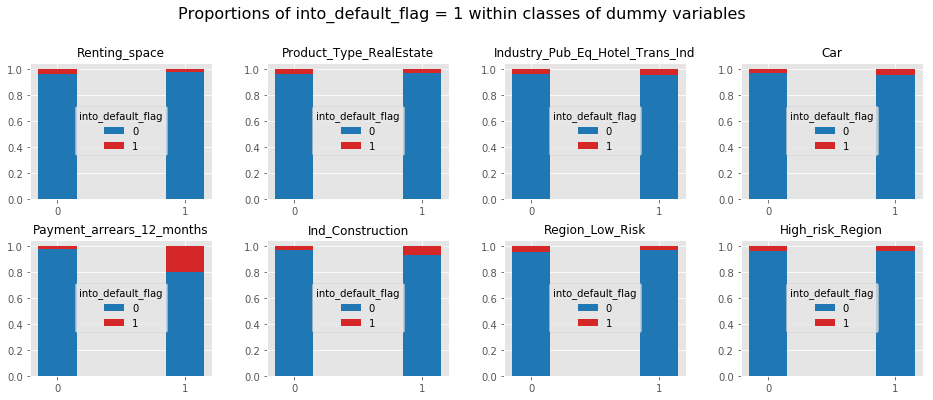

In [23]:
plt.figure(figsize=(16,6))
plt.suptitle('Proportions of into_default_flag = 1 within classes of dummy variables', fontsize=16)
bad_rates = pd.DataFrame(columns=cat_variables, index=[0,1])
plot_num = 1
for var in cat_variables:
    table = pd.crosstab(data[var], data[target], normalize='index')
    bad_rates[var] = table[1]
    plt.subplot(2, 4, plot_num)
    plt.bar(['0','1'], table[0], width=0.3, color='tab:blue')
    plt.bar(['0','1'], table[1], bottom=table[0], width=0.3, color='tab:red')
    plt.title(var, fontsize=12)
    plt.legend(table.columns, title=table.columns.name, loc='center',)
    plot_num += 1

plt.subplots_adjust(hspace=0.3, wspace=0.3, top=0.85)

In [24]:
bad_rates.transpose().round(3)

,0,1
Renting_space,0.038,0.023
Product_Type_RealEstate,0.038,0.031
Industry_Pub_Eq_Hotel_Trans_Ind,0.035,0.046
Car,0.026,0.045
Payment_arrears_12_months,0.020,0.198
Ind_Construction,0.033,0.066
Region_Low_Risk,0.042,0.033
High_risk_Region,0.037,0.039


__Let's check what are magnitudes of into_defualt_flag = 1 proportions changes for different categorical variables__

In [25]:
bad_rates_delta = (1-bad_rates.loc[0]/bad_rates.loc[1])*100
bad_rates_delta = bad_rates_delta.to_frame(name='% change')
bad_rates_delta['intuition (sing)'] = [0, 0, 0, 0, 1, 0, -1, 1]
bad_rates_delta['no contradiction'] = bad_rates_delta['% change']*bad_rates_delta['intuition (sing)']>=0
bad_rates_delta.round(3)

,% change,intuition (sing),no contradiction
Renting_space,-64.600,0,True
Product_Type_RealEstate,-23.938,0,True
Industry_Pub_Eq_Hotel_Trans_Ind,23.713,0,True
Car,40.602,0,True
Payment_arrears_12_months,89.661,1,True
Ind_Construction,49.258,0,True
Region_Low_Risk,-27.828,-1,True
High_risk_Region,5.842,1,True


***
#### Observations:
- The most significant infuence on default rate has __Payment_arrears_12_months__
- Other factors which seems to be good predictors are __Renting_space__, __Ind_Construction__ and __Car__
- __Region_Low_Risk__, __Product_Type_RealEstate__ and __Industry_Pub_Eq_Hotel_Trans_Ind__ also have satisfactory difference of defualt rate between buckets
- __High_risk_Region__ has law magnitude of default rate change
- Signs of effects do not contradict the intuition

We could validate our observations further on the stage of Single Factor Analysis
***

## Analysis of numerical variables

#### Distributions of numerical factors
Let's inspect the distributions of numerical factors and see how __into_default_flag=1__ is distributed in respect to factors' values.
<br> Below is function for drawing distributions of values and shares of into_default_flag=1 within buckets for a given factor. Further will use it to scrutinize numeric factors

In [26]:
def plot_dist_and_rate(data, target, var, bins, bound_round):
    fig, ax = plt.subplots(2,1)
    fig.set_size_inches(15,8)
    fig.suptitle(var, fontsize=15)
    plt.subplots_adjust(hspace=0.15, top=0.92)
    
    #binning and counting values within bins
    max_val, min_val = data[var].max(), data[var].min()
    bins_bounds = np.arange(min_val, max_val, (max_val-min_val)/bins )
    bins_bounds = np.append(bins_bounds, max_val)
    bins_labels = (bins_bounds[0:len(bins_bounds)-1] + bins_bounds[1:len(bins_bounds)])/2
    bins_labels = bins_labels.round(bound_round)
    df = data[[target, var]]
    with pd.option_context('mode.chained_assignment', None):
        df['binned'] = pd.cut(df[var], bins=bins_bounds, labels=bins_labels) #### include_lowest=True
    table = pd.crosstab(df['binned'], df[target], normalize='index')
    
    #draw distribution of values
    plot_dist = sns.distplot(data[var].dropna(), bins=bins, norm_hist=False, color='blue',
                             label='Distribution of '+data[var].name+' values', ax=ax[0])
    plot_dist.axes.set_xlabel('')
    plot_dist.set(xlim=(min_val,max_val), yticks=[])
    plot_dist.legend(prop={'size': 15}, loc='upper left')
    
    #draw proportions of into_default_flag=1 within bins
    plot_rate = sns.barplot(y=table[1].values, x=table.index.categories, color='red', alpha=0.7,
                            label='Proportion of '+target+'=1 within buckets', ax=ax[1])
    plt.setp(plot_rate.get_xticklabels(), rotation=45)
    plot_rate.legend(prop={'size': 15}, loc='upper left')
    
    return

Here we call the function and draw the distrubutions.

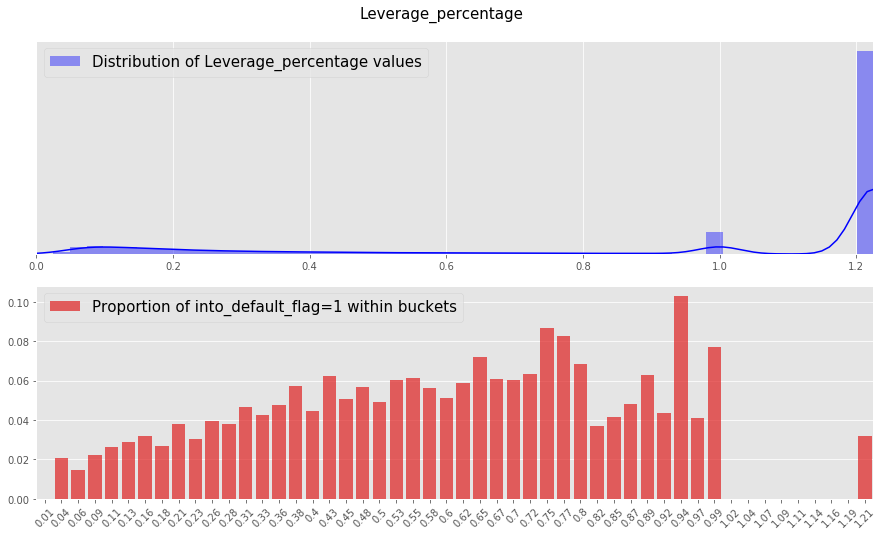

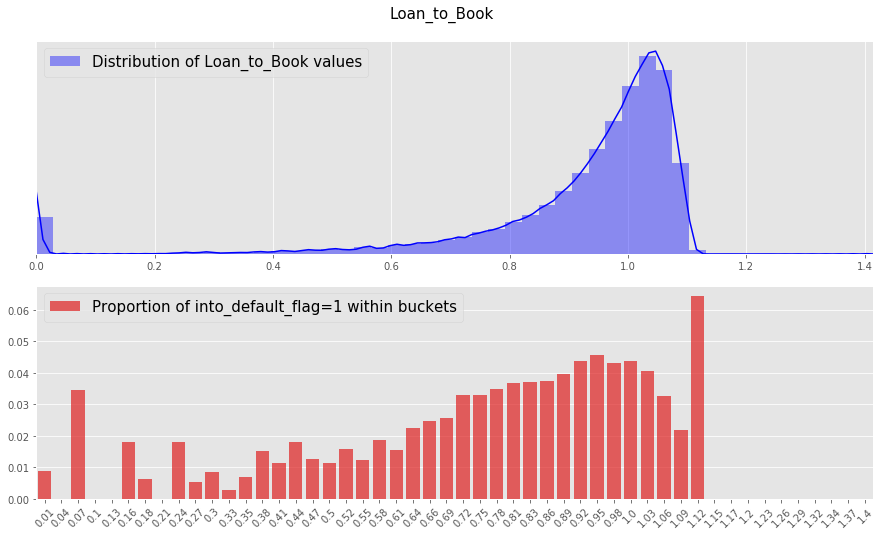

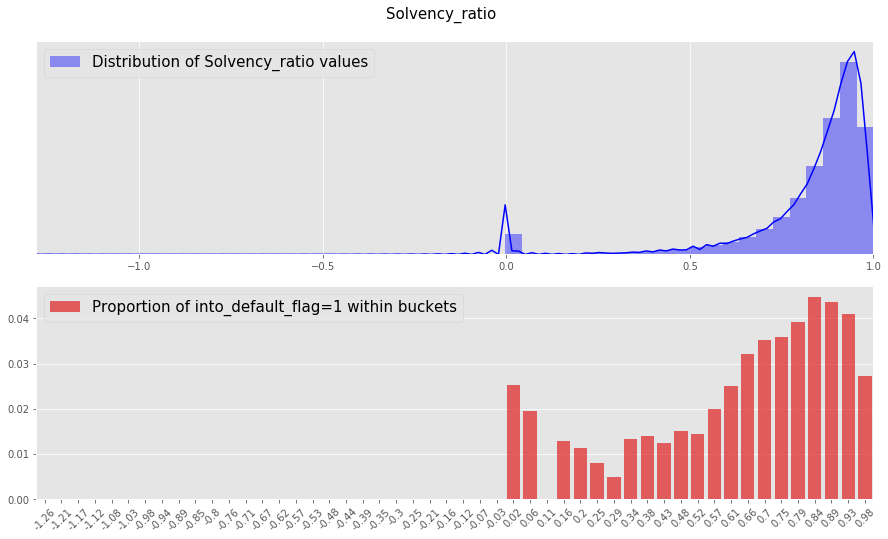

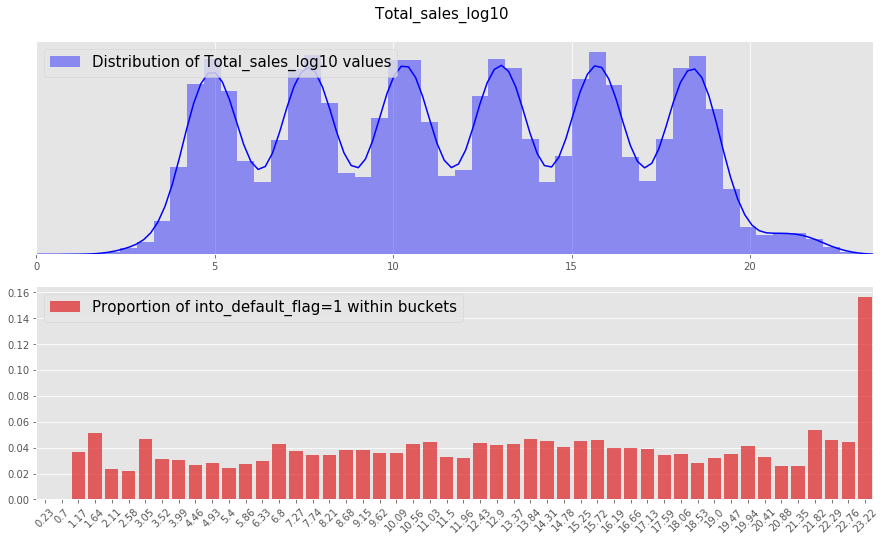

In [27]:
cols = [c for c in data if c in num_variables or c==target]
data_num = data[cols]
with pd.option_context('mode.chained_assignment', None):
    data_num['Total_sales_log10'] = np.log10(data['Total_sales'])
data_num = data_num.drop('Total_sales', axis=1)
for var in [c for c in data_num if c!=target]:
    plot_dist_and_rate(data_num, target, var, 50, 2)

***
#### Observations (distributions of factors' values):
- __Leverage_percentage:__ Distribution of Leverage_percentage has very large number of observations around value equal to 1. Also there is extreme number of observation with discrete value equal to 1.224811594 (more than 60% of the sample).
- __Loan_to_Book__ and __Solvency_ratio:__We can see that there are obvious anomalities in distributions of Loan_to_Book and Solvency_ratio. Large number of observations have factors' values which fall out of distributions - both Loan_to_Book and Solvency_ratio have abnormal number of observations with values equal to zero. This fact indicates that probably actual values of those factors are missing and zeros are just flaw of data.
- __Total_sales_log10:__ (logarithm of __Total_sales__ to base 10) has very inusual distribution. It looks like values of Total_sales are taken from several lognormal distributions with different means

#### Observations (proportion of into_default_flag=1 within buckets):
- __Leverage_percentage:__ Overall into_default_flag proportion increases with value of the factor. However, for Leverage_percentage=1.224811594 (as mentioned before there a great deal of observation with this exact value) falls out of the trend.
- __Loan_to_Book:__ Overall into_default_flag proportion increases with value of the factor except for range of values between 1.0 and 1.1. High proportion around value 1.12 cound be an outlier since there no so much observations within given bucket (the same is true for proportion in the range between 0.05 and 0.25).
- __Solvency_ratio:__ Overall into_default_flag proportion increases with value of the factor. Abnormal proportion could be observed in range of values between 0.0 and 0.4. As we found value of factor equal to zero could be indication of missing values, so it explains the devation. For other proportions, in range (0.0, 0.4) these are too many observations within buckets, thus proportions could deviate.
- __Total_sales_log10:__ proportion of into_default_flag=1 within buckets is pretty flat. It seems that this factor couldn't be helpful in predicting into_default_flag and probably the prediction power will be law.

To sum up analysis distributions showed that all numeric factors except Total_sales are potentially good predictors of into_default_flag. On the other hand, the analysis unveiled some flaws in raw data. We will discuss how to cope with this issues further.
***

#### Next we will inspect pairwise distributions of numeric factors. This will help us to observe outliers which we already discovered before. 

103.72316861152649

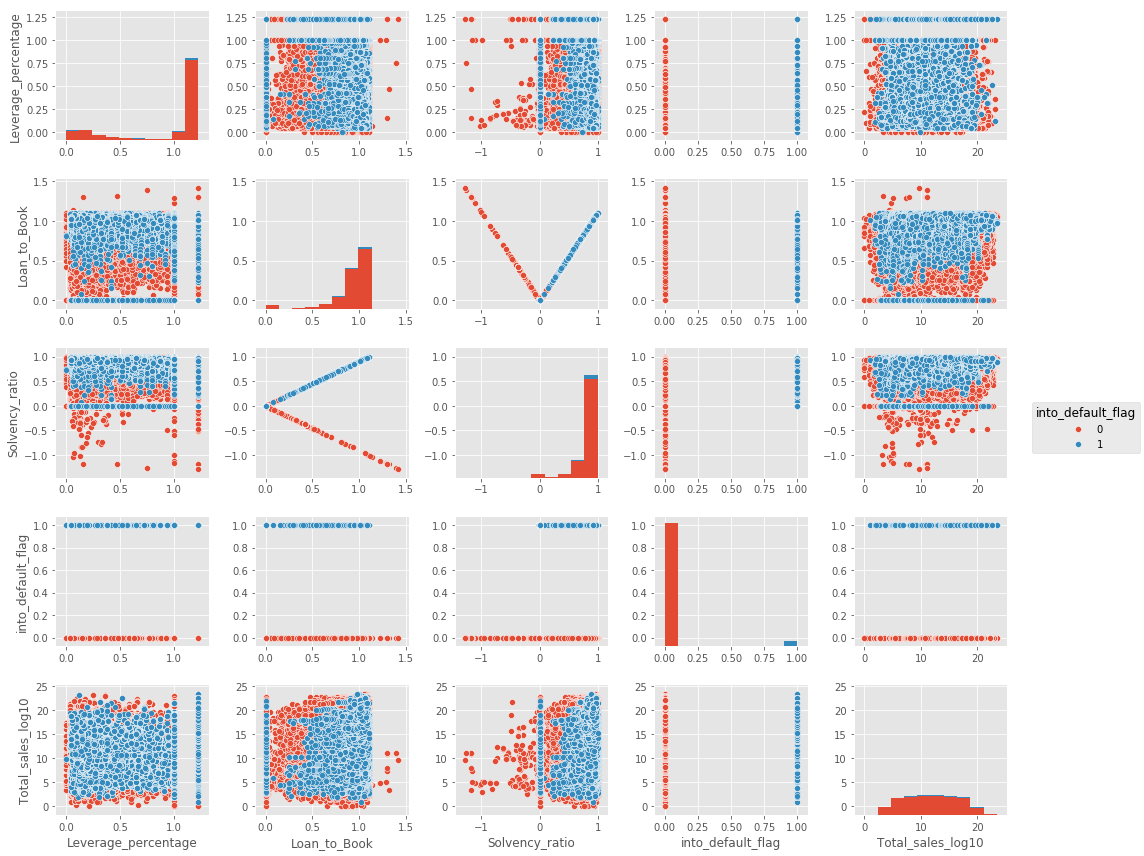

In [28]:
start_time = time.time()

pairplot = sns.pairplot(data_num.dropna(), hue=target, size=2.5)
pairplot.fig.set_size_inches(16,12)
plt.subplots_adjust(hspace=0.3, wspace=0.3)
del data_num

time.time() - start_time

#### Observations:
- __Loan_to_Book__ vs __Leverage_percentage__: from this plot we can see that observations with Loan_to_Book=0 are outliers. This provides us the evidence to support the hypothesis that Loan_to_Book=0 is actually an indication of missing value.
- __Solvency_ratio__ vs __Leverage_percentage__: from this plot we can see that observations with Solvency_ratio=0 are outliers. This provides us the evidence to support the hypothesis that Solvency_ratio=0 is actually an indication of missing value.
- __Total_sales_log10__ vs __Loan_to_Book__ and __Total_sales_log10__ vs __Solvency_ratio__ plots support the hypotheses above as well.
- __Solvency_ratio__ vs __Loan_to_Book__: on this plot we can see that all observations lies on two lines. It means that they are pretty correlated. After the observation of this fact, I have checked the ratios of values Solvency_ratio and Loan_to_Book and found that Loan_to_Book = 1.1045*|Solvency_ratio|. Actually there are just about 0.18% of observations with negative Solvency_ratio, thus factors have almost perfect correlation.
***

### Observed default rates

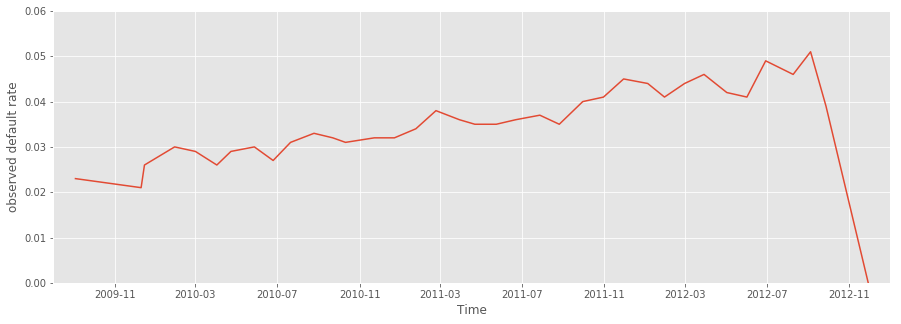

In [29]:
#observed default rates
data_dr = data[['RATING_DATE', 'ID']].groupby('RATING_DATE').count().merge(data[['RATING_DATE', 'into_default_flag']].groupby('RATING_DATE').mean(), left_index=True, right_index=True).round(3)

plt.figure(figsize=(15,5))
plt.plot(data_dr.index.values, data_dr[target].values)
plt.xlabel('Time')
plt.ylabel('observed default rate')
plt.ylim(0,0.06)
#plt.xlim(min(data_dr['RATING_DATE']), max(data_dr['RATING_DATE']))
plt.xlim('2009-08-01', '2013-01-01')
plt.show()

#plt.figure(figsize=(15,5))
#plt.plot(data_dr.index.values, data_dr['ID'].values)
#plt.xlim('2009-08-01', '2013-01-01')
#plt.show()

One can notice that default time is not stable over time (the latter value is an outlier since there just 4 observation for that date). In addition the sample do not cover full economic cycle. Since lenght of econmic cycles could vary from a couple of years up to 10 years we could only hypothesize how default rate could change further. It is important to undestand dynamics of default rates becouse besides perfromance on train and test sample, we need to undestand how this model will perform in practice.
So there two main hypothesis about future default rate:
- November 2012 is aproximately the midpoint of an economic cycle, thus in shortrun default rate will stay almost the same over 2012, and then will decrease
- The economic cycle is longer that 6-7 years, then potentially default rate could continue to increse 

There is definitely lack of information to judge about future default rates.
It is worth to mention that sample contains defaults not used to determine defualt within 12 months after rating date. The last rating date in the the sample is 2012-11-29. Defauts dates go up to 2014-09-30. It is obvious to undestant that default after 2013-11-29 are not accounted. We could somehow approximate "future" defaults rates by moving 12 months window and devide it by average number of client rated per rating date. Unfortunately it also unstable. In addition it would be incorrect to take future default since it underestimated due to lack of new vintages.
Nevertheless, let's check it.

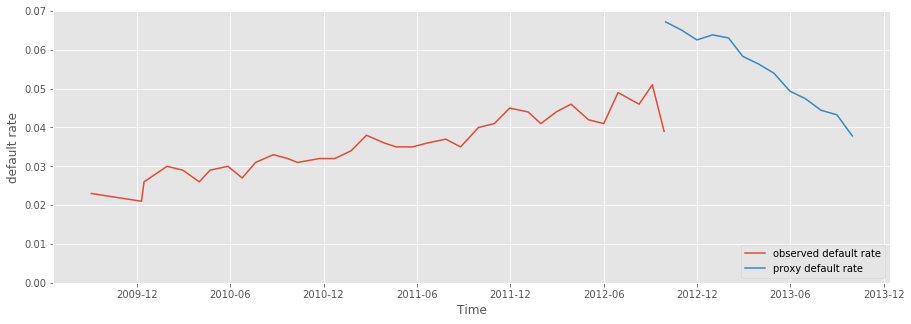

In [30]:
data_defaults = data[['ID','into_default_date']].dropna().drop_duplicates().sort_values(by=['into_default_date'])
data_defaults = data_defaults.loc[data_defaults['into_default_date']>'2012-09-27']

dates = data_defaults['into_default_date']
dates = dates.drop_duplicates()
date_end = dates.max() - relativedelta.relativedelta(years=1) + relativedelta.relativedelta(days=1)
dates_run = dates[dates<date_end]

defaults_num = pd.DataFrame(index=['date', 'defaults'])
for date in dates_run:
    lower = date
    upper = lower + relativedelta.relativedelta(years=1)
    window = data_defaults.loc[(data_defaults['into_default_date']>lower) & (data_defaults['into_default_date']<upper)]
    defaults_num[date] = date, len(window)
    
defaults_num = defaults_num.transpose()

data_dr['rat_date'] =''
data_dr['rat_date'] = data_dr.index 
avearge_num = data_dr[(data_dr['rat_date']>='2011-09-30') & (data_dr['rat_date']<='2012-09-27')].mean()['ID']

plt.figure(figsize=(15,5))
plt.xlabel('Time')
plt.ylabel('default rate')
plt.ylim(0,0.07)

plt.plot(data_dr.index.values[:-1], data_dr[target].values[:-1])
plt.plot(defaults_num.index, defaults_num.defaults.values/avearge_num)
plt.legend(['observed default rate', 'proxy default rate'], loc='lower right')

Also let' verify that increase of default rate is statistically significant.

In [31]:
y = data_dr[:-1]['into_default_flag'].values
X = data_dr[:-1].index.values
X = X - min(X)
X = X.astype('timedelta64[D]')
X = X.astype(int)

ols_model = sm.OLS(y,sm.add_constant(X))
ols_result = ols_model.fit()
print("\033[1m" + 'OLS with constant' + "\033[0;0m")
print(ols_result.summary().tables[1])

OLS with constant
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0234      0.001     25.388      0.000       0.021       0.025
x1          2.116e-05   1.38e-06     15.347      0.000    1.84e-05     2.4e-05


Coefficint for time is significant. We should analyze this topic deeper on the stage of Multiple Factor Analysis.

***
## Correlations between variables and multicollinearity analysis

#### Correlations analysis

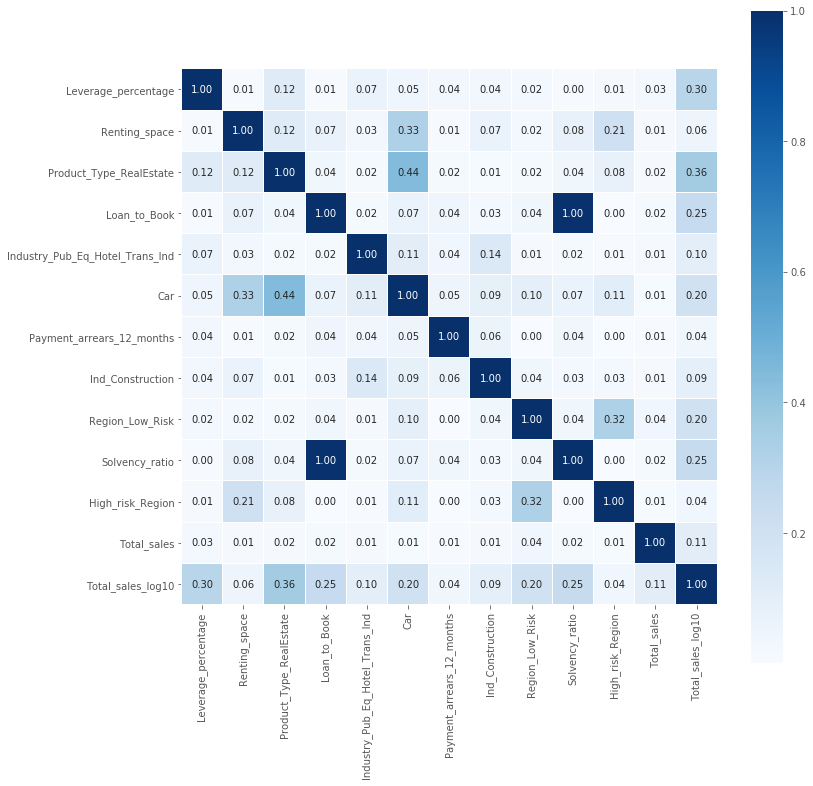

In [32]:
cols = [c for c in data if c in cat_variables or c in num_variables]
data_cor = data[cols]
with pd.option_context('mode.chained_assignment', None):
    data_cor['Total_sales_log10'] = np.log10(data['Total_sales'])
#data_cor = data_cor.drop('Total_sales', axis=1)
cor = data_cor.corr()
plt.figure(figsize=(12,12))
sns.heatmap(cor.abs(), vmax=1.0, cmap='Blues', annot=True, fmt='.2f', square=True, annot_kws={'size':10},
            linecolor='white', linewidths=0.1)

***
#### Observations:
- __Loan_to_Book__ vs __Solvency_ratio__ pair have perfect correlation (as we predicted earlier)
- Pairs with moderate correlation:
    - __Product_Type_RealEstate__ vs __Car__
    - __Product_Type_RealEstate__ vs __Total_sales_log10__
    - __Renting_space__ vs __Car__
    - __Region_Low_Risk__ vs __High_risk_Region__
- __Total_sales_log10__ overall correlates (~weakly) almost with all other variables
- Other pairs with weak correlation:
    - __Renting_space__ vs __High_risk_Region__
- other pair do not exhibit noticeable correlation 

We definetely can conlude that using both __Loan_to_Book__ and __Solvency_ratio__ together in the model in not an option.

***
#### Multicollinearity analysis
To detect multicollinearity will wil use __Variance inflation factor__ (VIF) which is widely used for this purpose (An Introduction to Statistical Learning, Gareth James et al.). To get VIF one should run simple OLS regressions of for each factor to other factors (tagret is not included). Further VIF is determined: 
$$ VIF_i = {1\over 1-R_i^2} $$
Different critical values for VIF could be chosen, although usaully critical value from 5 to 10 is used.
<br>_Note: function of statsmodels modeule works purely with large numbers, thus instead of Total sales will use auxiliary variable devided by 10^15_

In [33]:
with pd.option_context('mode.chained_assignment', None):
    data_cor['Total_sales_1e_15'] = data_cor['Total_sales']/1000000000000000
data_const = add_constant(data_cor.drop('Total_sales', axis=1).dropna())
vif = pd.Series(
    [variance_inflation_factor(data_const.values, i) for i in range(data_const.shape[1])], index =  data_const.columns)
vif = vif.to_frame(name='VIF')
vif.round(2)

,VIF
const,33.90
Leverage_percentage,1.11
Renting_space,1.29
Product_Type_RealEstate,1.59
Loan_to_Book,119.02
Industry_Pub_Eq_Hotel_Trans_Ind,1.06
Car,1.59
Payment_arrears_12_months,1.01
Ind_Construction,1.06
Region_Low_Risk,1.18


Not surprisingly VIFs for Loan_to_Book and Solvency_ratio are exttemely high since they are correlated between each other. Now let's drop one of the factors and see how it will affect VIFs.

In [34]:
data_const = data_const.drop('Loan_to_Book', axis=1)
vif = pd.Series(
    [variance_inflation_factor(data_const.values, i) for i in range(data_const.shape[1])], index =  data_const.columns)
vif = vif.to_frame(name='VIF')
vif.round(2)

,VIF
const,33.66
Leverage_percentage,1.11
Renting_space,1.29
Product_Type_RealEstate,1.59
Industry_Pub_Eq_Hotel_Trans_Ind,1.06
Car,1.59
Payment_arrears_12_months,1.01
Ind_Construction,1.06
Region_Low_Risk,1.18
Solvency_ratio,1.11


#### Conclusions of correlations ans multicollinearity analysis:
- VIFs are pretty low without Solvency_ratio that means multicollinearity is not the case and should not cause any problems.
- Some correlations are quite modarate, so we need to check how factors behave on the stage of Multifactor Analysis. To clirify how it affect the model we can run models with and without those factors and check how prediction power of models change.
***

### To sum up before we start Single Factor Analysis
#### Predictive potential of the factors:
- Among categorical factors __Payment_arrears_12_months__,  __Renting_space__, __Ind_Construction__ and __Car__ have high influence on into_default_flag. We can expect high prediction power for this factors.
- __Leverage_percentage__ and __Solvency_ratio__ have almost monotonous influence on into_default_flag in danse range of values.
- __Loan_to_Book__ was excluded from the analysis since its perfect colleraltion with __Solvency_ratio__
- __Total_sales__ has no influence on into_default_flag according to the qualitative analysis.

#### Missing values:
- It is worth mentining that __Solvency_ratio__ contains missing values where it equal to zero.
- Total_sales also has some missing values.

#### Dealing with missing values
There are different approaches to deal with missing values. Let's dive into the problem and discuss approaches and corresponding caveats, as well as pros and cons. The issue with missing values in case of numerical data is that we can't use them unless we transform them somehow or drop from the sample. The latter is the simpliest way (not best of course). However, if the objective is to use as much data as we can omitting data is not a option. To make make data applicable missing values should be substituted with some other values. Methods to substitute the missing values are:
- __Dummy variables substitution__. For example using Weight of Evidence (for definition and application see - Credit Risk Scorecards by Naeem Siddiqi), shortly WOE. WOE. Actually this method is implies creating new variable based on existing explanatory variable and target. But values of WOE depend on choice of buckets and could be unstable in the ranges where observations are sparse.
- __Factor feature substitution__. Substitute missing values with mean (or any other characteristic of factor's distribution) value of the factor. This approah is also on of the basic ones. This method is easily implemented. The most important thing is that it allows us to use the whole sample. On the other hand, usually it doesn't improve factor's predictive power since new values assigned to missing values are actually not observation specific. More advanced methods of factor specific features imputation implies condition based subsititution. Values to substitute are calculated for a range of observation with similar values of another factor. This could improve the predictive power. Yet thoughtful analysis of joint distributions of factors should be carried out to implement this approach.
- __Distrubution based substitution__ Distribution based approach also could be applied for the purpose of substitution. According to this approach values are drawn from empirical distribution of factor values (build based on existing values). Advantage of this method is that it does not cause distortion of existing distribution. On the other hand, it still does not capture entire observsation specific infromation.
- __Model based approach__ The most advanced method is model based imputation of missing values. Values to be substituted with are estimated via predictive model build on the sample without observations with missing values. That is in this model variable with missing values is dependent variable and all other factors are explanantory variables (real target of sample is not used). The advantage of this method is that missing values are substituted with observation spedific data rather some feature of the whole (or part of) the sample.
***

# Single Factor Analysis
For our convinience we will create data sample only dependent and explanatory variables:
<br>_Note: Loan to Book variable won't be included in X based on results of collinearity and multicollineariry analysis_

In [35]:
num_variables = [c for c in num_variables if c!='Loan_to_Book']
cols = [c for c in data if c==target or c in cat_variables or c in num_variables or c=='ID']
cols = cols[-1:] + cols[:-1]
data_yX = data[cols]

We found earlier that there are missing values in Total_sales. We can apply conditional median substitution - that is for every missing value we will calculate median for the same ID. Since Total_sales could be very fluctuative it better to use median insted of mean.

In [36]:
with pd.option_context('mode.chained_assignment', None):
    data_yX['Total_sales'] = data_yX[['ID','Total_sales']].groupby('ID').transform(lambda x: x.fillna(x.mean()))['Total_sales']
pd.isnull(data_yX['Total_sales']).value_counts()

False    796429
True        153
Name: Total_sales, dtype: int64

Nevetheless there is still some missing values we managed to reduce it from 7111 to 153 (more than tenfold), that is from ~1% to less than 0,02%. For the purpose of SFA the rest could be dropped. Before MLA we will try to replace the rest with some of substitution methods.

### Estimation of factors' infleunce and statistical significance
Here we will estimate teh magnitude of factors' influence on into_default_flag=1 and corresponding statistical significance. For the purpose of analysis logistic regression is used

In [37]:
def one_factor_model(data, var, target, dropna=False, silent=False):
    yX = data[[target, var]]
    if dropna==True:
        yX = pd.DataFrame(yX.dropna()).reset_index(drop=True)
    y, X = yX[target], yX[var]
    if silent==False:
        print("\033[1m" + var + "\033[0;0m")
    logit_model = sm.Logit(y, add_constant(X))
    result = logit_model.fit(disp=False)
    if silent==False:
        print(result.summary().tables[1], '\n')
    return result.params[1], result.pvalues[1]

In [38]:
res = pd.DataFrame(index=['Logit_coef','p_value'])
print("\033[1m" + "\033[4m" + 'Categorical variables'.upper() + "\033[0m" + "\033[0;0m", '\n')
for var in cat_variables:
    coef_pvalue = one_factor_model(data_yX, var, target, dropna=False, silent=False)
    res[var] = coef_pvalue
print("\033[1m" + "\033[4m" + 'Numerical variables'.upper() + "\033[0m" + "\033[0;0m", '\n')
for var in num_variables:
    coef_pvalue = one_factor_model(data_yX, var, target, dropna=True, silent=False)
    res[var] = coef_pvalue
print("\033[1m" + "\033[4m" + 'Summary of one factor regressions'.upper() + "\033[0m" + "\033[0;0m")

res = res.transpose()
res['odds_ratio'] = np.exp(res['Logit_coef'])
res['abs_coef'] = res['Logit_coef'].abs()
res.sort_values(by=['abs_coef'], ascending=False).drop(['abs_coef'], axis=1).round(4)

CATEGORICAL VARIABLES 

Renting_space
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -3.2300      0.006   -529.869      0.000      -3.242      -3.218
Renting_space    -0.5138      0.028    -18.654      0.000      -0.568      -0.460

Product_Type_RealEstate
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      -3.2276      0.006   -503.235      0.000      -3.240      -3.215
Product_Type_RealEstate    -0.2222      0.017    -13.017      0.000      -0.256      -0.189

Industry_Pub_Eq_Hotel_Trans_Ind
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const   

,Logit_coef,p_value,odds_ratio
Payment_arrears_12_months,2.4689,0.0000,11.8098
Ind_Construction,0.7126,0.0000,2.0393
Solvency_ratio,0.6376,0.0000,1.8919
Car,0.5397,0.0000,1.7154
Renting_space,-0.5138,0.0000,0.5982
Industry_Pub_Eq_Hotel_Trans_Ind,0.2821,0.0000,1.3259
Region_Low_Risk,-0.2550,0.0000,0.7749
Product_Type_RealEstate,-0.2222,0.0000,0.8007
High_risk_Region,0.0626,0.0033,1.0646
Leverage_percentage,0.0010,0.9431,1.0010


#### Obsetvations:
- All Logit coefficients for corresponding one factor regressions are statistically significant (even at 1% confidence level) except __Leverage_percentage__
- __Payment_arrears_12_months__ has the most prominent coefficicent and influence on odds ratio.
- __Ind_Construction__, __Solvency_ratio__, __Car__ and __Renting_space__ have signigicant coefficients and impact on odds ratio
- __Industry_Pub_Eq_Hotel_Trans_Ind__, __Region_Low_Risk__, __Product_Type_RealEstate__ have have moderate coefficients and impact on odds ratio
- __High_risk_Region__, __Leverage_percentage__, __Total_sales__ have insignificant influence on odds ratio

__Note__: Despite the fact that __Leverage_percentage__ has noticeable increase of into_default_flag=1 proportion on the range between 0 and 1 factor turned to have insignificant coefficeint in one factor regression. This could indicate that abnormal concentration of observations with Leverage_percentage equal to 1.224811594 is actually a flow of data. To check this hypothesis we will run regression without observations with abnormal value and see how the result would change.

In [39]:
var = 'Leverage_percentage'
yX = data_yX[[target, var]]
res = pd.DataFrame(index=['Logit_coef','p_value'])
coef_pvalue = one_factor_model(yX[yX[var]<1], var, target, dropna=True, silent=False)
res[var] = coef_pvalue
res = res.transpose()
res['odds_ratio'] = np.exp(res['Logit_coef'])
res['abs_coef'] = res['Logit_coef'].abs()
res.sort_values(by=['abs_coef'], ascending=False).drop(['abs_coef'], axis=1).round(4)

Leverage_percentage
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -3.7073      0.019   -195.046      0.000      -3.745      -3.670
Leverage_percentage     1.4263      0.041     34.611      0.000       1.345       1.507



,Logit_coef,p_value,odds_ratio
Leverage_percentage,1.4263,0.0,4.1631


Now __Leverage_percentage__ performs better. Since more than half of the sample have such values we definetely need to handle this issue properly. Let's try to substitute abnormal values with mean conditional on __ID__.

In [40]:
#yX = data[[target, var, 'ID']]
mask = data_yX['Leverage_percentage'] > 1
with pd.option_context('mode.chained_assignment', None):
    data_yX.loc[mask, 'Leverage_percentage'] = np.nan
    print(pd.isnull(data_yX['Leverage_percentage']).value_counts(), '\n')
    data_yX['Leverage_percentage'] = data_yX[['ID','Leverage_percentage']].groupby('ID').transform(lambda x: x.fillna(x.mean()))['Leverage_percentage']
print(pd.isnull(data_yX['Leverage_percentage']).value_counts())

True     514369
False    282213
Name: Leverage_percentage, dtype: int64 

True     499326
False    297256
Name: Leverage_percentage, dtype: int64


In [41]:
print(len(data_yX['ID'].unique()), 'Total unique IDs' )
print(data_yX.groupby('ID')['Leverage_percentage'].mean().isnull().sum(),
      'IDs for which all Leverage_percentage has abnormal value')

40967 Total unique IDs
25736 IDs for which all Leverage_percentage has abnormal value


There are still many observation for conditional mean substitution. 25736 IDs do not have Leverage_percentage value diffrent from 1.224811594.

Let's try unconditinal mean substitution.

In [42]:
var = 'Leverage_percentage'
res = pd.DataFrame(index=['Logit_coef','p_value'])
coef_pvalue = one_factor_model(data_yX.fillna(data_yX['Leverage_percentage'].mean()),
                               var, target, dropna=True, silent=False)
res[var] = coef_pvalue
res = res.transpose()
res['odds_ratio'] = np.exp(res['Logit_coef'])
res['abs_coef'] = res['Logit_coef'].abs()
res.sort_values(by=['abs_coef'], ascending=False).drop(['abs_coef'], axis=1).round(4)

Leverage_percentage
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -3.8862      0.014   -286.399      0.000      -3.913      -3.860
Leverage_percentage     1.3414      0.024     54.813      0.000       1.293       1.389



,Logit_coef,p_value,odds_ratio
Leverage_percentage,1.3414,0.0,3.8246


If mean substitution is used the coefficient is still significant and comparable with one without substitution (when NaN observations are dropped).

***
### Predictive power of the factors
There is a number of differenet mertics used to measure predictive power. Among them are:
- Gini coefficient
- ROC-AUC (Reciever Operator Characteristic / Area Under the Curve)
- Kholmogorov-Smirnov statistic (KS-stattistic)
- Information value (IV)
- Bayesian Error Score
- Kendall's tau
- Somer's D

Of course that is not full list of metrics used to judge predictive power. Other metrics as well as discussion and comparison could be found the following papers:
- Studies on the Validation of Internal Rating Systems, Working Paper No. 14, 2005, BCBS
- Credit Risk Scorecards, Developing and Implementing Intelligent Credit Scoring, Naeem Siddiqi, 2006
- A practical approach to validating a PD model, Lydian Medema et al., Journal of Banking & Finance, Volume 33, Issue 4, 2009
- How to Measure the Quality of Credit Scoring Models, Martin ŘEZÁČ & František ŘEZÁČ, Czech Journal of Economics and Finance, 61, 2011, no. 5

Somer's D and Kendall's tau are usally used when shadow rating model is developed, i.e. in case of law default potrfolio which is not the case. Bayesian error score is equivalent to KS-statistic.  Gini and ROC-AUC are widely used and considered one of the best practice metrics. They are easily calculated, intuitive and well interpreted. For the  purpose of current analysis Gini and ROC-AUC will be used. It is worth mentining that Gini and ROC-AUC are actually interconnected, thus we need to calculate just one of them.
***

### ROC and ROC-AUC
First the function for drawing ROC curve and calsulaion of  ROC-AUC and Gini is defined.

In [43]:
# function to draw set of roc curve graphs and return an array of roc-aucs and ginis
def draw_roc_auc(data_train, data_test, var_cols):
    res = pd.DataFrame(index=['gini_train_%', 'gini_test_%', 'roc_auc_train', 'roc_auc_test'])
    
    raws, cols = int(len(var_cols)/3)+1, 3
    plt.figure(figsize=(17, 5*raws+1*(raws-1)))
    plt.subplots_adjust(wspace = 0.3, hspace = 0.3)
    
    i = 1
    for var in var_cols:
        data_train_var = data_train[[target, var]]
        data_test_var = data_test[[target, var]]
        data_train_var = data_train_var.dropna()   ##dropping NaNs for sample with only target and variable
        data_test_var = data_test_var.dropna()     ##dropping NaNs for sample with only target and variable

        y_train, y_test = data_train_var[target], data_test_var[target] 
        X_train, X_test = data_train_var[var], data_test_var[var]

        logit_model = sm.Logit(y_train, add_constant(X_train))
        result = logit_model.fit(disp=False)
        y_train_hat =  result.predict(add_constant(X_train))
        y_test_hat =  result.predict(add_constant(X_test))

        roc_auc_train = roc_auc_score(y_train, y_train_hat)
        roc_auc_test = roc_auc_score(y_test, y_test_hat)
        gini_train = 2*roc_auc_train-1
        gini_test = 2*roc_auc_test-1
        fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_hat)
        fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_hat)

        plt.subplot(raws, cols, i)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.title(var)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.plot(fpr_train, tpr_train)
        plt.plot(fpr_test, tpr_test)
        plt.plot([0, 1], [0, 1], color='grey')
        plt.legend(['train AUC = {:.2f}'.format(roc_auc_train),
                    'test_AUC = {:.2f}'.format(roc_auc_test),
                    'random AUC = 0.5'], loc='lower right')
        i += 1
        res[var] = 100*gini_train, 100*gini_test, roc_auc_train, roc_auc_test
    plt.show()
    return res

For the purpose of metrics calculation we will split the data set to train and test sets. We will check how metrics perfrom both on train and test sets. 

In [44]:
random_state = 42
data_train, data_test = train_test_split(data_yX, test_size=0.3, random_state=random_state)
var_cols = [c for c in data_train if c not in ['into_default_flag','ID']]

res_train = pd.DataFrame(index=['Logit_coef_train', 'p_value_train'])
res_test = pd.DataFrame(index=['Logit_coef_test','p_value_test'])
for var in var_cols:
    coef_pvalue = one_factor_model(data_train, var, target, dropna=True, silent=True)
    res_train[var] = coef_pvalue
for var in var_cols:
    coef_pvalue = one_factor_model(data_test, var, target, dropna=True, silent=True)
    res_test[var] = coef_pvalue
print("\033[1m" + "\033[4m" + 'Summary of one factor regressions for train and test samples'.upper() + "\033[0m" + "\033[0;0m")

res_train = res_train.transpose()
res_test = res_test.transpose()
res = res_train.merge(res_test, left_index=True, right_index=True)
res['abs_coef_test'] = res['Logit_coef_test'].abs()
res.sort_values(by=['abs_coef_test'], ascending=False).drop(['abs_coef_test'], axis=1).round(4)

SUMMARY OF ONE FACTOR REGRESSIONS FOR TRAIN AND TEST SAMPLES


,Logit_coef_train,p_value_train,Logit_coef_test,p_value_test
Payment_arrears_12_months,2.4684,0.0000,2.4701,0.0000
Leverage_percentage,1.1700,0.0000,1.2312,0.0000
Ind_Construction,0.7044,0.0000,0.7317,0.0000
Solvency_ratio,0.6280,0.0000,0.6605,0.0000
Car,0.5421,0.0000,0.5341,0.0000
Renting_space,-0.5280,0.0000,-0.4813,0.0000
Industry_Pub_Eq_Hotel_Trans_Ind,0.2839,0.0000,0.2778,0.0000
Region_Low_Risk,-0.2595,0.0000,-0.2443,0.0000
Product_Type_RealEstate,-0.2200,0.0000,-0.2275,0.0000
High_risk_Region,0.0605,0.0176,0.0675,0.0832


***
Now let's draw ROC curves with function defined before.

<br>___Note:___ the function constructed to build ROC curves and calculate AUC and Gini drops NaNs by default. NaNs are dropped only when sample with target and variable is chosen, thus dropping all observations with NaNs do not affect one factor models for varibales with no NaNs (dedicated lines are marked in code above)

ROC CURVES


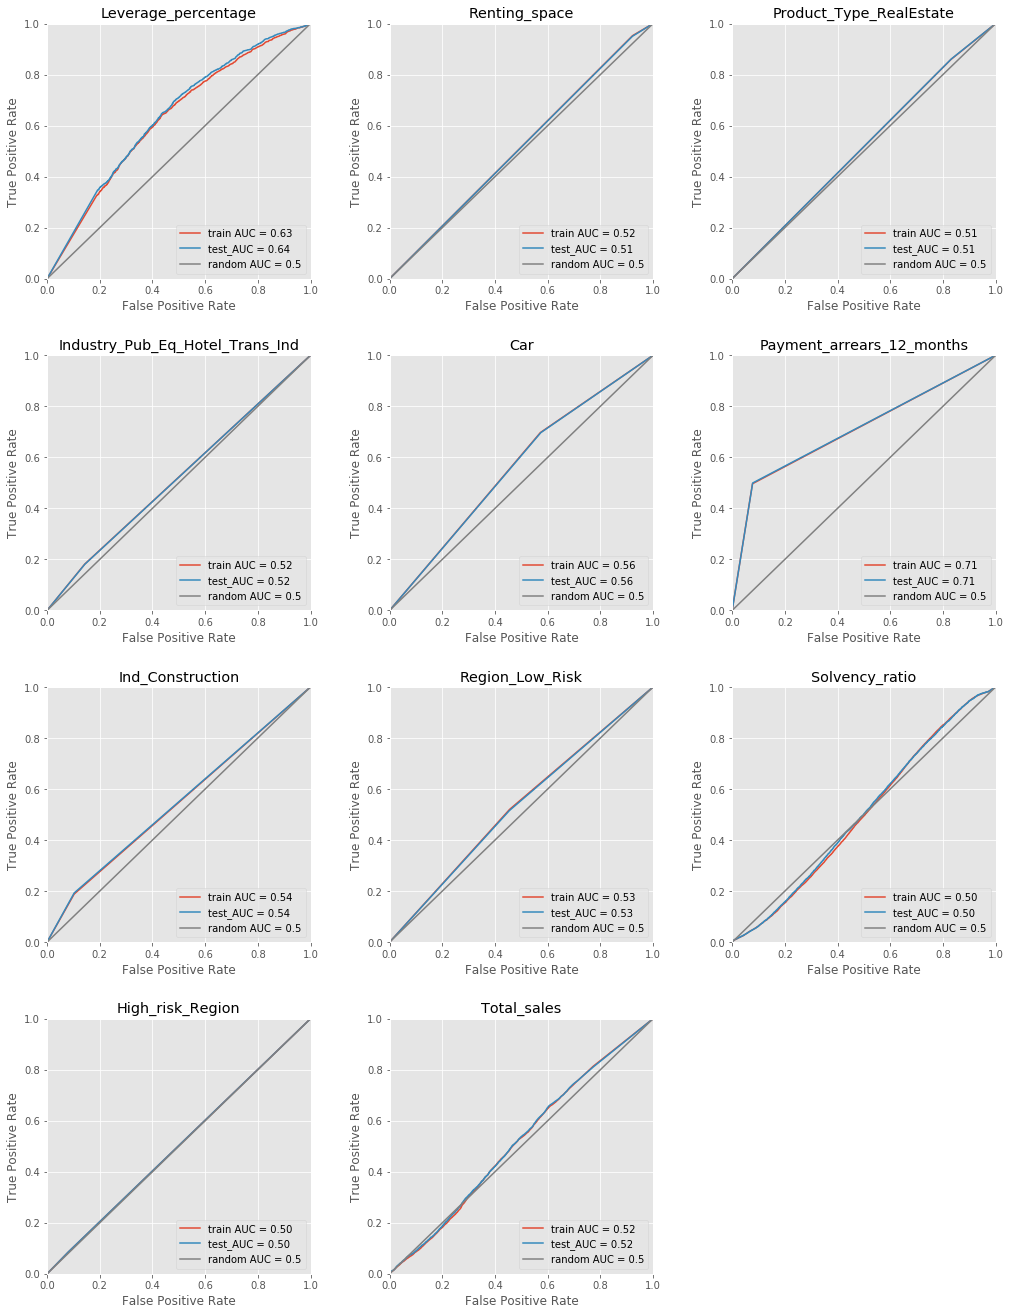

SUMMARY OF AUC & GINI


,gini_train_%,gini_test_%,roc_auc_train,roc_auc_test
Payment_arrears_12_months,41.93,42.15,0.71,0.71
Leverage_percentage,25.56,27.33,0.63,0.64
Car,12.48,12.29,0.56,0.56
Ind_Construction,8.54,8.97,0.54,0.54
Region_Low_Risk,6.48,6.09,0.53,0.53
Industry_Pub_Eq_Hotel_Trans_Ind,3.85,3.76,0.52,0.52
Total_sales,3.32,3.73,0.52,0.52
Product_Type_RealEstate,2.88,2.95,0.51,0.51
Renting_space,3.05,2.85,0.52,0.51
Solvency_ratio,-0.07,0.69,0.50,0.50


In [45]:
var_cols = [c for c in data_train if c not in ['into_default_flag','ID']]

print("\033[1m" + "\033[4m" + 'ROC curves'.upper() + "\033[0m" + "\033[0;0m")
res = draw_roc_auc(data_train, data_test, var_cols)
print("\033[1m" + "\033[4m" + 'Summary of AUC & Gini'.upper() + "\033[0m" + "\033[0;0m")
res.transpose().round(2).sort_values(by=['gini_test_%'], ascending=False)

To construct curves for Leverage_percentage and Total_sales obsevations with no ID match to replace abnormal values were dropped. Let's also costruct curves with mean replacing.

ROC CURVES


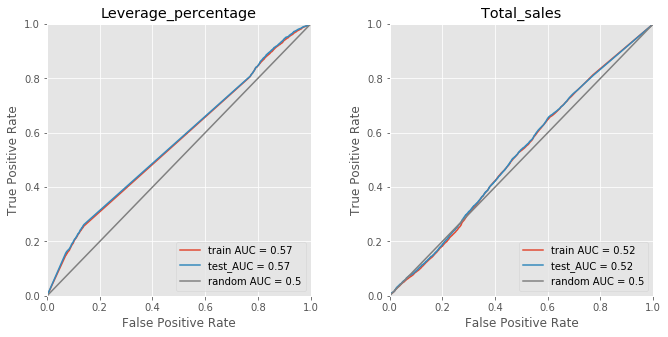

SUMMARY OF AUC & GINI


,gini_train_%,gini_test_%,roc_auc_train,roc_auc_test
Leverage_percentage,13.12,13.85,0.57,0.57
Total_sales,3.43,3.87,0.52,0.52


In [46]:
var_cols = ['Leverage_percentage', 'Total_sales']
data_train = data_train.fillna(data_train.mean())
data_test = data_test.fillna(data_test.mean())

print("\033[1m" + "\033[4m" + 'ROC curves'.upper() + "\033[0m" + "\033[0;0m")
res = draw_roc_auc(data_train, data_test, var_cols)
print("\033[1m" + "\033[4m" + 'Summary of AUC & Gini'.upper() + "\033[0m" + "\033[0;0m")
res.transpose().round(2).sort_values(by=['gini_test_%'], ascending=False)

***
### Short list of factors based on SLA and Preliminary Analysis
Based on results of Preliminary analysis and Single Factor Analysis a shortlist of factors to be included in the Multiple Factor Analysis was created. To include factors in the list following criteria were applied:
- Intuitive direction of factor's influence on target
- Enough number of observations within range where change of factor's value drives a noticeable increase or dicrease of defaults rate.
- Statistical significance together with sufficient magnitude of the effect
- Predictive power of the factor

As a result following factor were chosen:
- Payment_arrears_12_months
- Leverage_percentage
- Car
- Ind_Construction
- Industry_Pub_Eq_Hotel_Trans_Ind
- Region_Low_Risk
- Renting_space
- Solvency_ratio

Payment_arrears_12_months and Leverage_percentage are the best factors among factors. Ind_Construction and Car are good enough.

Total_sales, High_risk_Region, Product_Type_RealEstate are not included in the list due to its poor characteristics

In [47]:
print(round((time.time() - code_time)/60, 1))

7.0


# Multiple Factor Analysis
If there are plenty of factors various technics are used to choose best perfroming combination:
- Forward Selection: process starts with the set of best factor, then more factors are added 
- Backward Elimination: process starts with all factors, further factors are eliminated
- Stepwise: combination of first two algorithms, every step one factor is added and another is eliminated

Since there are only 8 factors in the shortlist it is decided to include them all in the final model. Let' see the results of logistic regression with selected factors.

In [48]:
cols = [c for c in data if c in cat_variables or c in num_variables]
cols = [c for c in cols if c not in ['Total_sales', 'High_risk_Region', 'Product_Type_RealEstate']]
#cols = [c for c in data_train if c not in ['into_default_flag','ID',
#                                           'Total_sales', 'High_risk_Region', 'Product_Type_RealEstate']]

y_train, y_test = data_train[target], data_test[target]
X_train, X_test = data_train[cols], data_test[cols]

logit_model = sm.Logit(y_train, add_constant(X_train))
result = logit_model.fit(disp=False)
print(result.summary())

                           Logit Regression Results                           
Dep. Variable:      into_default_flag   No. Observations:               557607
Model:                          Logit   Df Residuals:                   557598
Method:                           MLE   Df Model:                            8
Date:                Fri, 01 Jun 2018   Pseudo R-squ.:                  0.1535
Time:                        19:01:01   Log-Likelihood:                -74583.
converged:                       True   LL-Null:                       -88109.
                                        LLR p-value:                     0.000
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                              -5.4182      0.050   -107.399      0.000      -5.517      -5.319
Leverage_percentage                 0.9265      0.032     29.344    

__We see that all factor are statistically significant at minimal significance levels. Joint hypothesis, $H_0: \beta_i=0$, is also rejected.__

'Pseudo R-squ' is McFadden’s pseudo-R-squared:
- http://www.statsmodels.org/dev/generated/statsmodels.discrete.discrete_model.DiscreteResults.html
- https://stats.idre.ucla.edu/other/mult-pkg/faq/general/faq-what-are-pseudo-r-squareds/

Below function to draw ROC curve and calculate ROC-AUC and Gini is defined. 

_Note: functionality of this function is similar to one defined in SFA. The latter one was tailored for convinient output of several plots_

In [49]:
# function to draw roc curve for model selected varibales and return roc-auc and gini
def model_roc_auc(result, y_train, y_test, X_train, X_test, legend1, legend2): 
    y_train_hat =  result.predict(add_constant(X_train))
    y_test_hat =  result.predict(add_constant(X_test))

    #res = pd.DataFrame(index=['gini_train_%', 'gini_test_%', 'roc_auc_train', 'roc_auc_test'])
    res = pd.DataFrame(index=['gini_'+legend1+'_%', 'gini_'+legend2+'_%', 'roc_auc_'+legend1, 'roc_auc_'+legend2])

    roc_auc_train = roc_auc_score(y_train, y_train_hat)
    roc_auc_test = roc_auc_score(y_test, y_test_hat)
    gini_train = 2*roc_auc_train-1
    gini_test = 2*roc_auc_test-1

    fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_hat)
    fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_hat)

    plt.figure(figsize=(6,6))
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    #plt.title('Selected model')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.plot(fpr_train, tpr_train)
    plt.plot(fpr_test, tpr_test)
    plt.plot([0, 1], [0, 1], color='grey')
    
    #legend1 = 'train'
    #legend2 = 'test'
    plt.legend([legend1 +' AUC = {:.2f}'.format(roc_auc_train),
                legend2 +' AUC = {:.2f}'.format(roc_auc_test),
                'random AUC = 0.5'], loc='lower right')
    res['model'] = 100*gini_train, 100*gini_test, roc_auc_train, roc_auc_test
    plt.show()
    return res

### Predictive power of the model in train and test samples
Let's see how model performs on train and test samples

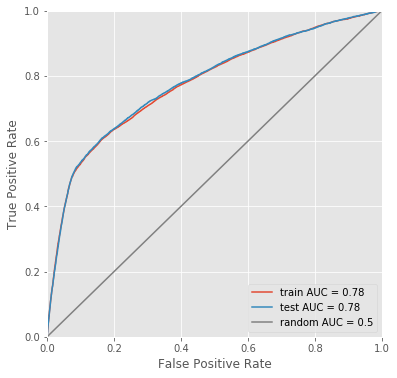

,gini_train_%,gini_test_%,roc_auc_train,roc_auc_test
model,55.46,55.96,0.78,0.78


In [50]:
res = model_roc_auc(result, y_train, y_test, X_train, X_test, 'train', 'test')
res.transpose().round(2)

#### Observations:
- The model has strong predictive power with Gini equal to almost 56% on test sample
- Gini and ROC-AUC do not vary significanly on train and test samples

***
### Distribution of observations conditional on into_default_flag
First let's check how all observations' scores are distributed for train and test samples

Text(0.5,1,'train and test scores')

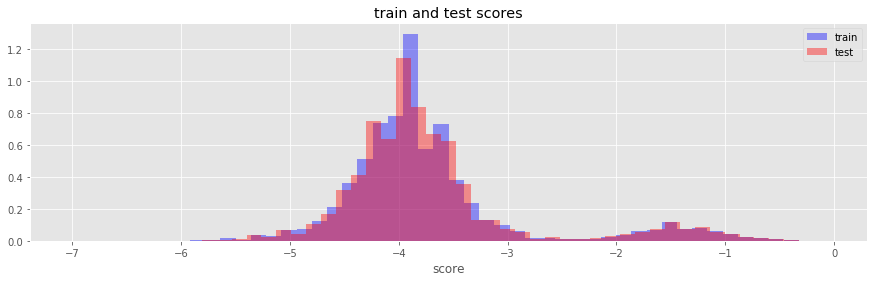

In [51]:
y_hat = result.predict(add_constant(X_train))
score = np.log( y_hat/(1-y_hat) )
score_train = pd.DataFrame()
score_train['score'] = score
score_train['y_hat'] = y_hat
score_train['y_train'] = y_train
score_train = score_train.sort_values(by=['score'])

y_hat = result.predict(add_constant(X_test))
score = np.log( y_hat/(1-y_hat) )
score_test = pd.DataFrame()
score_test['score'] = score
score_test['y_hat'] = y_hat
score_test['y_test'] = y_test
score_test = score_test.sort_values(by=['score'])

plt.figure(figsize=(15,4))
sns.distplot(score_train['score'], bins=50, kde=False, norm_hist=True, color='blue')
sns.distplot(score_test['score'], bins=50, kde=False, norm_hist=True, color='red')
plt.legend(['train', 'test'])
plt.title('train and test scores')

Distributions for train and test samples do not exibit significant deviations from each other.

In [52]:
print ( len(score_train[score_train['score']<-6]), len(score_train[score_train['score']>0]) )
print ( len(score_test[score_test['score']<-6]), len(score_test[score_test['score']>0]) )

42 0
16 0


There are some outliers with values less that -6 which we will drop.

In [53]:
score_train = score_train[score_train['score']>-6]
score_test = score_test[score_test['score']>-6]

Now let's inspect conditional distributions

Text(0.5,1,'test into_default_flag=0/1')

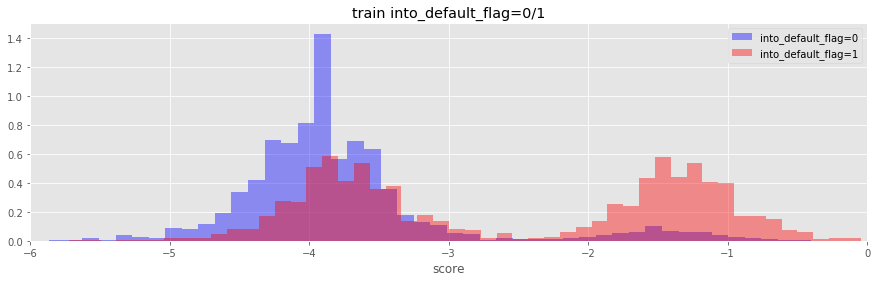

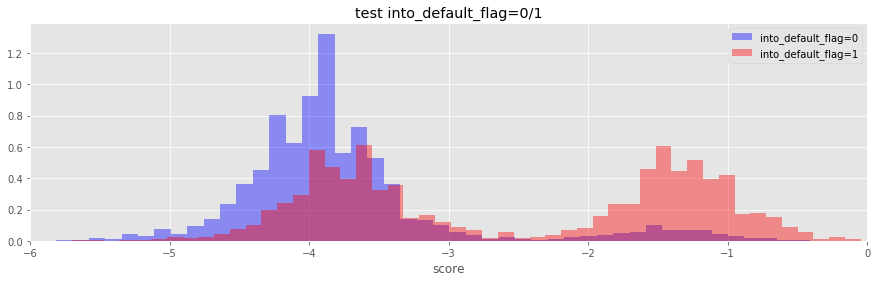

In [54]:
score_train_good = score_train[score_train['y_train']==0]
score_train_bad = score_train[score_train['y_train']==1]

score_test_good = score_test[score_test['y_test']==0]
score_test_bad = score_test[score_test['y_test']==1]

plt.figure(figsize=(15,4))
plt.xlim(-6,0)
sns.distplot(score_train_good['score'], bins=50, kde=False, norm_hist=True, color='blue')
sns.distplot(score_train_bad['score'], bins=50, kde=False, norm_hist=True, color='red')
plt.legend(['into_default_flag=0', 'into_default_flag=1'])
plt.title('train into_default_flag=0/1')

plt.figure(figsize=(15,4))
plt.xlim(-6,0)
sns.distplot(score_test_good['score'], bins=50, kde=False, norm_hist=True, color='blue')
sns.distplot(score_test_bad['score'], bins=50, kde=False, norm_hist=True, color='red')
plt.legend(['into_default_flag=0', 'into_default_flag=1'])
plt.title('test into_default_flag=0/1')

We see that both train and test sample exibit adequate conditional (on into_default_flag) distrubutions.

### Chi-square (Hosmer-Lemeshow) test on train and test samples
First we should bucket observations. We will bucket them based on score value (which is equivalent to choosing PD intervals). Disrtibutions shape also should be taken into account while choosing intervals' bounds since there ranges with low density. Estimare of Chi-square mean (for one given interval) calculated on interval with low density is unreliable because of low number of observations and as a consequence has high standart error. 

In [55]:
bins_bounds = np.arange(-6, 0.01, 1)
bins_bounds = np.append(bins_bounds, [-2.5, -0.5])
bins_bounds = np.append(bins_bounds, np.arange(-5, -3, 0.25))
bins_bounds = np.append(bins_bounds, np.arange(-2, -0.5, 0.25))
bins_bounds = np.unique(bins_bounds)
bins_bounds = np.sort(bins_bounds)
bins_labels = bins_bounds[:-1]

Now let's calculate the metric itself

In [56]:
#bucket observations in train and test
with pd.option_context('mode.chained_assignment', None):
    score_train['binned'] = pd.cut(score_train['score'], bins=bins_bounds, include_lowest=True) #labels=bins_labels,
score_train.groupby('binned').mean()

with pd.option_context('mode.chained_assignment', None):
    score_test['binned'] = pd.cut(score_test['score'], bins=bins_bounds, include_lowest=True) #labels=bins_labels,

#calculate probabilities of default within bucket in train
def_train = score_train.groupby('binned').sum()
tot_train = score_train.groupby('binned').count()
prob = def_train['y_train']/tot_train['y_train']

#create table with observed defaults, total observed and corresponding probabilties within each bucket
def_test = score_test.groupby('binned').sum()
tot_test = score_test.groupby('binned').count()['y_test'].values
test_stat = def_test.drop(['y_hat', 'score'], axis=1)
test_stat = test_stat.rename(index=str, columns={'y_test':'observed'})
test_stat['total'] = tot_test
test_stat['p_i'] = prob.values

#calculate chi2-statistic, degrees of freedom and p-value
test_stat['expected'] = test_stat['total']*test_stat['p_i']
test_stat['up'] = test_stat['expected'] - test_stat['observed']
test_stat['up'] = test_stat['up']*test_stat['up']
test_stat['down'] = test_stat['expected']*(1-test_stat['p_i'])
test_stat['chi2'] = test_stat['up']/test_stat['down']
test_stat = test_stat.drop(['up','down'], axis=1)
test_stat = test_stat.dropna()
chi2_stat = test_stat['chi2'].sum()
df = len(test_stat['chi2']) - 1
p_val = 1 - stats.chi2.cdf(chi2_stat, df)

print('chi2 =', chi2_stat, '\ndf =', df, '\np-value =', p_val)
test_stat

chi2 = 13.357398094873203 
df = 17 
p-value = 0.71195118525


,observed,total,p_i,expected,chi2
binned,,,,,
"(-6.001, -5.0]",30,4254,0.006759,28.754506,0.054315
"(-5.0, -4.75]",41,4640,0.009589,44.491979,0.276723
"(-4.75, -4.5]",104,11698,0.009408,110.052655,0.336044
"(-4.5, -4.25]",295,25987,0.010518,273.334074,1.735613
"(-4.25, -4.0]",585,43114,0.014201,612.270830,1.232154
"(-4.0, -3.75]",1126,60143,0.019505,1173.114841,1.929877
"(-3.75, -3.5]",1085,40336,0.026382,1064.153714,0.419435
"(-3.5, -3.25]",616,16090,0.037531,603.876452,0.252886
"(-3.25, -3.0]",319,7102,0.047763,339.211521,1.264685


We see that statistic is not large enough to reject the null hypothesis that into_default_flag is distributed differently on train and test sets. Or to be theoretically precise - there is no significant evidence to reject the null hypothesis.

***
### Out of sample performance
As we discovered while preliminary analysis there is significant increase of observed default rate from September 2009 to September 2012. Let's try to see how the model perfroms out of time. We will split the sample by RATING_DATE. All observations with RATING_DATE>2012-01-30 will be put in out-of-time sample, the rest will be placed in development sample. Cutoff date was chosen based on a condition that 70% of observations with into_default_flag=1 would be included into development sample.

In [57]:
cutoff_date = '2012-01-30'
data_yX_date = data_yX.join(data['RATING_DATE'])
bound = pd.to_datetime(cutoff_date)
data_recent = data_yX_date[data_yX_date['RATING_DATE']>bound]
data_train = data_yX_date[data_yX_date['RATING_DATE']<=bound]

dev, out = len(data_train), len(data_recent)
tot = dev+out
print('Out-of-sample size', out, round(100*out/tot, 1), '%')
print('Development sample size', dev, round(100*dev/tot, 1), '%')

Out-of-sample size 192751 24.2 %
Development sample size 603831 75.8 %


Train the model on development sample

In [58]:
cols = [c for c in data if c in cat_variables or c in num_variables]
cols = [c for c in cols if c not in ['Total_sales', 'High_risk_Region', 'Product_Type_RealEstate']]

data_train = data_train.fillna(data_train.mean())
data_recent = data_recent.fillna(data_recent.mean())

y_train, X_train = data_train[target], data_train[cols]                 
y_recent, X_recent = data_recent[target], data_recent[cols]

logit_model = sm.Logit(y_train, add_constant(X_train))
result = logit_model.fit(disp=True)
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.126711
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:      into_default_flag   No. Observations:               603831
Model:                          Logit   Df Residuals:                   603822
Method:                           MLE   Df Model:                            8
Date:                Fri, 01 Jun 2018   Pseudo R-squ.:                  0.1523
Time:                        19:01:20   Log-Likelihood:                -76512.
converged:                       True   LL-Null:                       -90256.
                                        LLR p-value:                     0.000
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                              -5.4084      0.048   -113.153  

#### Performance of the model on development and out-of-time samples

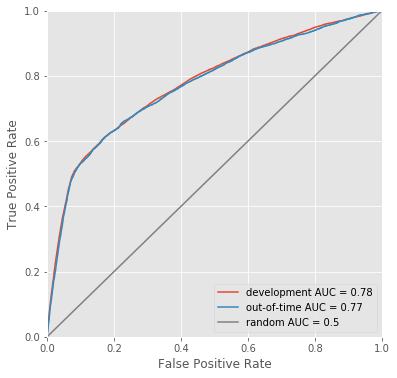

,gini_development_%,gini_out-of-time_%,roc_auc_development,roc_auc_out-of-time
model,55.48,54.61,0.78,0.77


In [59]:
res = model_roc_auc(result, y_train, y_recent, X_train, X_recent, 'development', 'out-of-time')
res.transpose().round(2)

The model have comparable predictive power on out-of-time sample 

***
### Distribution of observations conditional on into_default_flag
First let's check how all observations' scores are distributed for development and out-of-time samples

Text(0.5,1,'train and test scores')

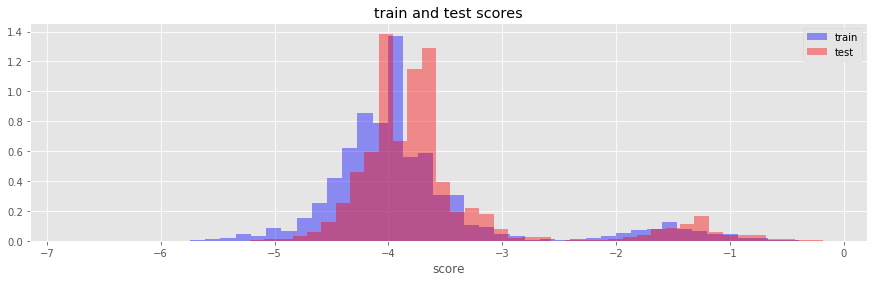

In [60]:
y_hat = result.predict(add_constant(X_train))
score = np.log( y_hat/(1-y_hat) )
score_train = pd.DataFrame()
score_train['score'] = score
score_train['y_hat'] = y_hat
score_train['y_train'] = y_train
score_train = score_train.sort_values(by=['score'])

y_hat = result.predict(add_constant(X_recent))
score = np.log( y_hat/(1-y_hat) )
score_test = pd.DataFrame()
score_test['score'] = score
score_test['y_hat'] = y_hat
score_test['y_test'] = y_recent
score_test = score_test.sort_values(by=['score'])

plt.figure(figsize=(15,4))
sns.distplot(score_train['score'], bins=50, kde=False, norm_hist=True, color='blue')
sns.distplot(score_test['score'], bins=50, kde=False, norm_hist=True, color='red')
plt.legend(['train', 'test'])
plt.title('train and test scores')

In [61]:
print ( len(score_train[score_train['score']<-6]), len(score_train[score_train['score']>0]) )
print ( len(score_test[score_test['score']<-6]), len(score_test[score_test['score']>0]) )

39 0
2 0


In [62]:
score_train = score_train[score_train['score']>-6]
score_test = score_test[score_test['score']>-6]

Text(0.5,1,'test into_default_flag=0/1')

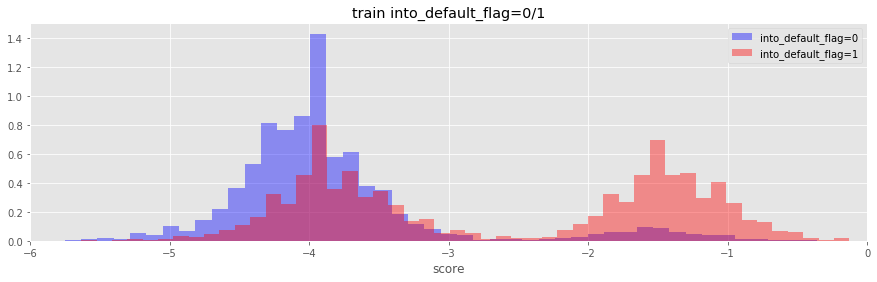

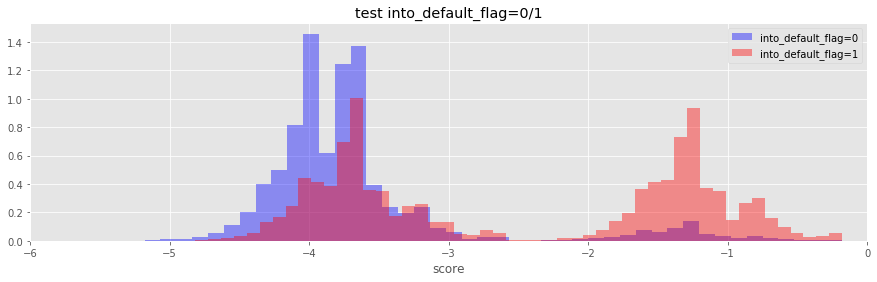

In [63]:
score_train_good = score_train[score_train['y_train']==0]
score_train_bad = score_train[score_train['y_train']==1]

score_test_good = score_test[score_test['y_test']==0]
score_test_bad = score_test[score_test['y_test']==1]

plt.figure(figsize=(15,4))
plt.xlim(-6,0)
sns.distplot(score_train_good['score'], bins=50, kde=False, norm_hist=True, color='blue')
sns.distplot(score_train_bad['score'], bins=50, kde=False, norm_hist=True, color='red')
plt.legend(['into_default_flag=0', 'into_default_flag=1'])
plt.title('train into_default_flag=0/1')

plt.figure(figsize=(15,4))
plt.xlim(-6,0)
sns.distplot(score_test_good['score'], bins=50, kde=False, norm_hist=True, color='blue')
sns.distplot(score_test_bad['score'], bins=50, kde=False, norm_hist=True, color='red')
plt.legend(['into_default_flag=0', 'into_default_flag=1'])
plt.title('test into_default_flag=0/1')

### Chi-square (Hosmer-Lemeshow) test on train and test samples
Now let's run chi-square test which for development and out-of-time samples.

In [64]:
bins_bounds = np.arange(-6, 0.01, 1)
bins_bounds = np.append(bins_bounds, [-2.5, -0.5])
bins_bounds = np.append(bins_bounds, np.arange(-5, -3, 0.25))
bins_bounds = np.append(bins_bounds, np.arange(-2, -0.5, 0.25))
bins_bounds = np.unique(bins_bounds)
bins_bounds = np.sort(bins_bounds)
bins_labels = bins_bounds[:-1]

In [65]:
#bucket observations in train and test
with pd.option_context('mode.chained_assignment', None):
    score_train['binned'] = pd.cut(score_train['score'], bins=bins_bounds, include_lowest=True) #labels=bins_labels,
score_train.groupby('binned').mean()

with pd.option_context('mode.chained_assignment', None):
    score_test['binned'] = pd.cut(score_test['score'], bins=bins_bounds, include_lowest=True) #labels=bins_labels,

#calculate probabilities of default within bucket in train
def_train = score_train.groupby('binned').sum()
tot_train = score_train.groupby('binned').count()
prob = def_train['y_train']/tot_train['y_train']

#create table with observed defaults, total observed and corresponding probabilties within each bucket
def_test = score_test.groupby('binned').sum()
tot_test = score_test.groupby('binned').count()['y_test'].values
test_stat = def_test.drop(['y_hat', 'score'], axis=1)
test_stat = test_stat.rename(index=str, columns={'y_test':'observed'})
test_stat['total'] = tot_test
test_stat['p_i'] = prob.values

#calculate chi2-statistic, degrees of freedom and p-value
test_stat['expected'] = test_stat['total']*test_stat['p_i']
test_stat['up'] = test_stat['expected'] - test_stat['observed']
test_stat['up'] = test_stat['up']*test_stat['up']
test_stat['down'] = test_stat['expected']*(1-test_stat['p_i'])
test_stat['chi2'] = test_stat['up']/test_stat['down']
test_stat = test_stat.drop(['up','down'], axis=1)
test_stat = test_stat.dropna()
chi2_stat = test_stat['chi2'].sum()
df = len(test_stat['chi2']) - 1
p_val = 1 - stats.chi2.cdf(chi2_stat, df)

print('chi2 =', chi2_stat, '\ndf =', df, '\np-value =', p_val)
test_stat

chi2 = 192.02142483702306 
df = 17 
p-value = 0.0


,observed,total,p_i,expected,chi2
binned,,,,,
"(-6.001, -5.0]",0,335,0.006524,2.185461,2.199812
"(-5.0, -4.75]",2,833,0.010178,8.478076,5.000778
"(-4.75, -4.5]",44,3639,0.009140,33.259092,3.500734
"(-4.5, -4.25]",194,14922,0.010974,163.755652,5.647867
"(-4.25, -4.0]",584,37397,0.014154,529.324243,5.728736
"(-4.0, -3.75]",965,45972,0.020003,919.570568,2.290154
"(-3.75, -3.5]",1463,49757,0.026984,1342.667125,11.083590
"(-3.5, -3.25]",566,11443,0.036247,414.769449,57.214535
"(-3.25, -3.0]",402,7782,0.046647,363.006937,4.393453


#### Results of Chi-square test on out-of-time sample
Unfortunately, we see that model build on the development sample perfrorms poorly "in the future" - on out-of-time sample. It means that the calibration should be applied.

***
### Calibration of the model
Now let's dive a bit into theory. There is one interesting fact that Logistic Regression is actually actually Linear Model. Linear comes from idea that observations in the hyperspace with dimensionality equal to number of factors. Now for a moment let's recall what we discussed in the preface of a the current analysis regarding classical clasification problem. To solve that problem one just need to find the equation of hypersurface which splits the hypersapce of factors so that objects with different are on opposite sides. In case of Regression Problem probability to be class=1 is associated with infinite number of hypersurfaces. Back to Earth again, actually those hypesurfaces are given by simple linear equation:

$$ B_0+B_1x_1+...+B_nx_n=0 $$

Now let's write a term which stands in ligistic regression:

$$ Score=\beta_0+\beta_1x_1+...+\beta_nx_n $$

Actually is the same thing but just differently written.
When distribution of factors changes it lead to transformation of the set of surfaces (let's drop hyper prefix for the sake of simplicity). More specifically the transformation is described by two parameters:

$$ Score' = A+B*Score $$

How we can find those parameters? Just run a simple linear regression. To do that we need to calculate score for all observations in the sample and sort them from smallest to largest. Then the sample is diveded to buckets. In each bucket average score is calcliated. $Score'$ is calculated as $ln({DR\over1-DR})$ since we don't have real probabilities for observed defaults.

For the purpose of current analysis we will train the model on the whole sample and calibrate it based on most recent observations. 

In [66]:
#cutoff_date = '2012-06-29'
upper_date = '2012-09-04'
lower_date = '2012-06-29'
data_yX_date = data_yX.join(data['RATING_DATE'])
#bound = pd.to_datetime(cutoff_date)
upper = pd.to_datetime(upper_date)
lower = pd.to_datetime(lower_date)
#data_recent = data_yX_date[data_yX_date['RATING_DATE']>=bound]
data_recent = data_yX_date[(data_yX_date['RATING_DATE']>=lower) & (data_yX_date['RATING_DATE']<=upper)]
data_train = data_yX_date

out =len(data_recent)
tot = len(data_train)
print('Out-of-sample size', out, round(100*out/tot, 1), '%')

Out-of-sample size 72999 9.2 %


In [67]:
data_train = data_train.fillna(data_train.mean())
data_recent = data_recent.fillna(data_recent.mean())

y_train, X_train = data_train[target], data_train[cols]                 
y_recent, X_recent = data_recent[target], data_recent[cols]

logit_model = sm.Logit(y_train, add_constant(X_train))
result = logit_model.fit(disp=True)
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.133664
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:      into_default_flag   No. Observations:               796582
Model:                          Logit   Df Residuals:                   796573
Method:                           MLE   Df Model:                            8
Date:                Fri, 01 Jun 2018   Pseudo R-squ.:                  0.1538
Time:                        19:01:42   Log-Likelihood:            -1.0647e+05
converged:                       True   LL-Null:                   -1.2583e+05
                                        LLR p-value:                     0.000
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                              -5.4468      0.042   -128.536  

First, we calculate average scores for fitted and observed values.

In [68]:
y_recent_hat = result.predict(add_constant(X_recent))

p = y_recent_hat
score = np.log( p/(1-p) )
score_table = pd.DataFrame()
score_table['score'] = score
score_table['y_recent_hat'] = y_recent_hat
score_table['y_recent'] = y_recent
score_table = score_table.sort_values(by=['score'])

bins = 30
max_val, min_val = score_table['score'].max(), score_table['score'].min()
bins_bounds = np.arange(min_val, max_val, (max_val-min_val)/bins )
bins_bounds = np.append(bins_bounds, max_val)
bins_labels = (bins_bounds[0:len(bins_bounds)-1] + bins_bounds[1:len(bins_bounds)])/2

with pd.option_context('mode.chained_assignment', None):
    score_table['binned'] = pd.cut(score_table['score'], bins=bins_bounds, labels=bins_labels, include_lowest=True)
score_table = score_table.groupby('binned').mean()
dr = score_table['y_recent']
score_table['score_1'] = np.log( dr/(1-dr) )
    #warning comes from this line, it doesn't affect the result since next line eliminates infs
score_table = score_table.replace([np.inf, -np.inf], np.nan).dropna()

#plt.plot(score_table['score'], score_table['score_1'])

C:\Users\Konstantin.Singurov\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log


Now let's run OLS

In [69]:
y = score_table['score'].values
X = score_table['score_1'].values.reshape(-1, 1)

ols_model = sm.OLS(y,sm.add_constant(X))
ols_result = ols_model.fit()
print("\033[1m" + 'OLS with constant' + "\033[0;0m")
print(ols_result.summary().tables[1])

ols_model = sm.OLS(y,X)
ols_result = ols_model.fit()
print("\033[1m" + 'OLS without constant' + "\033[0;0m")
print(ols_result.summary().tables[1])

B, B0, se = ols_result.params[0], 1, ols_result.bse[0]
tt = (B-B0)/se
n = len(y)
pval = stats.t.sf(np.abs(tt), n-1)*2
print("\033[1m" + 'p-value for H0: coef=1 is equal to {:.3f}'.format(pval) + "\033[0;0m")

OLS with constant
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1502      0.093     -1.617      0.122      -0.344       0.044
x1             0.9768      0.034     29.112      0.000       0.907       1.047
OLS without constant
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0238      0.017     58.659      0.000       0.987       1.060
p-value for H0: coef=1 is equal to 0.187


Constant is insignificant in first regression, thus OLS without constant is estimated. Testing $H_0: B=1$ gives p-value nor so good as we would like to confirm that coefficient significantly differs from 1. However we determined that the model should be calibrated. Thus we will use the coefficient to adjust the estimates for the whole model.

In [70]:
logit_coefs = pd.DataFrame()
logit_coefs['factor'] = result.params.index
logit_coefs['logit_coef'] = result.params.values
B = ols_result.params[0]
logit_coefs_cal = pd.DataFrame()
logit_coefs_cal['factor'] = logit_coefs['factor']
logit_coefs_cal['logit_coef'] = B*logit_coefs['logit_coef']
logit_coefs.to_csv('logit_coefs.csv', index=False)
logit_coefs_cal.to_csv('logit_coefs_cal.csv', index=False)

#print(logit_coefs, '\n')
#print(logit_coefs_cal)

In [71]:
print(round((time.time() - code_time)/60, 1))

7.7
